## Autopsy SNV analysis primarily using PacBio outputs

### Packages:

In [1]:
suppressMessages({
message("Loading packages")
library('ggplot2')
library('reshape2')
library('plyr')
library('tidyverse')
library('dplyr')
library('glue')
library("pals")
library("viridis")
library("igraph")
library("gggenes")
library("ggpubr")
library("Biostrings")
})

In [2]:
message("Set working directory and load additional functions")
wkdir = '/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources'
setwd(wkdir) # set working directory
message("Load in functions and Plot prep")
source(glue("{wkdir}/scripts/autopsy_extra.R"))

Set working directory and load additional functions

Load in functions and Plot prep



In [3]:
# set cutoffs: 
cov_requirement = 10 # total count cutoff of 10X for consensus mutants
percent_requirement = 0.80 # % genome covered at __X rd
minor_cov_lenient = 10  # lenient cutoff 
minor_cov_stringent = 100 # stringent cutoff ACTUAL 100
minor_freq = 0.05 # minor variant freq requirement ACTUAL: 0.05
minor_freq_lenient = 0.02 #0.02
ntlist = c('A','G','T','C','-') 
timo_cov = 200
timo_minorfreq = 0.02 # actually 0.02

In [4]:
# from nonsyn python code: 
total_syn = 9755
total_nonsyn = 19510
total_positions = 29265 # coding regions ONLY - no utrs

In [5]:
message("Generate figure directories")

FIG_DIR = glue("{wkdir}/figures/")  # set up figure directory for outputs

if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }

message('figures will be saved in: ', FIG_DIR)

Generate figure directories

figures will be saved in: /Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources/figures/



# Input Files:

### Variant files for PacBio (r1_files) and short-read (merged replicates, s_files)

In [6]:
# pacbio and short-read timo data: 
r1_files = Sys.glob(glue("{wkdir}/data/pacbio/*"), dirmark = FALSE) # pacbio BWA data - which we will use
s_files = Sys.glob(glue("{wkdir}/data/short_read/*"), dirmark = FALSE) # short-read BWA data

### Project metadata and files:

In [7]:
summary_meta = read.csv(glue('{wkdir}/data/summary_data.csv'))  # summary data of virus abundance

meta = merge(read.csv(glue('{wkdir}/data/autopsy_meta.v3.csv')), summary_meta, 
                by = c('detailed_location')) %>% 
            rowwise() %>%
            mutate(cpe = ifelse(CPE == 'yes', 1, ifelse(CPE == 'no', 0, NA))) # fill in 0's/NA

meta$general_location = factor(meta$general_location, levels = orderit) # order locations for figures

meta$pacbio_name = gsub("-","_",meta$name) # adjust names for data merging

### Gene regions (Wuhan-1 ref)

In [8]:
# gene info for genome maps:
gene_info = read.csv(glue('{wkdir}/data/sars-cov-2-features.5.csv'))

### AY119:

In [9]:
# ay119 info:
fasta_files = Sys.glob(glue("{wkdir}/data/ay119_aa-consensus/*.fasta"), dirmark = FALSE)
ay119_fasta = Sys.glob(glue("{wkdir}/data/ay119_nucleotide-consensus.fasta"), dirmark = FALSE)

## AY.119 reference to compare to

In [10]:
ay119_aadf = data.frame()
for (f in fasta_files){
    t = buildAA(f, 'ay119_aa')
    ay119_aadf = rbind(ay119_aadf, t)
}
ay119_ntdf = buildNT(ay119_fasta, 'ay119_nt')

# Pulling variant data

### Timo files: PacBio BWA alignment

In [11]:
filt_list = c() # ntpos positions w/ consensus variant to filter ALL files with later
min_filt_list = c() # ntpos positions w/ minor variant to filter ALL files with later
COV_DF1 = data.frame() # for coverage data

# r1 files = pacbio BWA alignments:
for (f in r1_files){ #
    t = appendVoc(ay119_aadf, ay119_ntdf, f) # add ref info to compre to
    temp_list = returnConList(t, 'ay119_nt', 5, 0.01)  # filter con data using very lenient filters - compares to ay119 ref
    temp_minlist = returnMinList(t, ntlist, minor_cov_lenient, 0.01)  # just pulls minor if minor col populated
    filt_list = c(filt_list, temp_list) # returns list of consensus pos
    min_filt_list = c(min_filt_list, temp_minlist)  # returns list of minor pos
    
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 10, percent_requirement)) # pulling coverage information for figures
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 50, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 100, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 200, percent_requirement))
}

filt_list = c(levels(factor(filt_list)))  # factor list - remove dups
min_filt_list = c(levels(factor(min_filt_list)))

condf1 = data.frame() # dataframes to populate with ntpos data info
mindf1 = data.frame()
low_cov1 = data.frame() # to determine samples that fail
for (f in r1_files){
    t = appendVoc(ay119_aadf, ay119_ntdf, f) # add ay119 information for final dataframe
    temp_cov = t %>% filter(totalcount < cov_requirement) %>% select(name, gene_id, ntpos) %>% unique() # low cov info
    low_cov1 = rbind(low_cov1, temp_cov) # add to final dataframe
    tempdf = grabPositions(t, filt_list) # temp consensus df
    temp_mindf = grabPositions(t, c(min_filt_list, filt_list)) # temp minor df
    condf1 = rbind(condf1, tempdf) # combine all samples together
    mindf1 = rbind(mindf1, temp_mindf) # combine all samples together
}

# pulling out orf1a/1b info to append to our df later:
orf_info1 = rbind(mindf1, condf1 %>% select(all_of(colnames(mindf1)))) %>%
                filter(!gene_id %in% nsps) %>% # select gene ids that are not nsps - these are the translated regions
                select(ntpos, aapos, gene_id, ay119_aa, ay119_nt) %>% 
                unique() %>%
                group_by(ntpos) %>%
                dplyr::rename("orf_gene_id" = "gene_id","orf_aapos" = "aapos")  %>%
            arrange(ntpos)

# filter out orf1a/b, combine with metadata 
condf1_nsps = merge(condf1 %>% filter(!gene_id %in% c('ORF1a', 'ORF1b')), meta, by.x = c('name'), by.y = c('pacbio_name'), all.x = TRUE)
mindf1_nsps = merge(mindf1 %>% filter(!gene_id %in% c('ORF1a', 'ORF1b')), meta, by.x = c('name'), by.y = c('pacbio_name'), all.x = TRUE)

### Timo files: Short-read BWA alignment
#### Here replicates were combined into one alignment to increase read depth and coverage across the genome

In [12]:
sr_condf = data.frame() # short-read con
sr_mindf = data.frame() # short-read min

for (f in s_files){ 
    t = appendVoc(ay119_aadf, ay119_ntdf, f)
    tempdf = grabPositions(t, filt_list)
    temp_mindf = grabPositions(t, c(min_filt_list, filt_list))     
    sr_condf = rbind(sr_condf, tempdf)
    sr_mindf = rbind(sr_mindf, temp_mindf)
}

sr_condf_nsps = merge(sr_condf %>% filter(!gene_id %in% c('ORF1a','ORF1b')), meta, by = c('name'), all.x = TRUE)  # will use for now - to filter etc. 
sr_mindf_nsps = merge(sr_mindf %>% filter(!gene_id %in%  c('ORF1a','ORF1b')), meta, by = c('name'), all.x = TRUE)  # will use for now - to filter etc. 

orf_info2 = rbind(sr_mindf, sr_condf %>% select(all_of(colnames(sr_mindf)))) %>%
                filter(!gene_id %in% nsps) %>% # select gene ids that are not nsps - these are the translated regions
                select(ntpos, aapos, gene_id, ay119_aa, ay119_nt) %>% 
                unique() %>%
                group_by(ntpos) %>%
                dplyr::rename("orf_gene_id" = "gene_id", 
                       "orf_aapos" = "aapos")  %>%
    arrange(ntpos)


# Metadata Figures: 

Does coverage data reflect the sgRNA/ddPCR results?

In [13]:
low_cov1 = low_cov1 %>% group_by(name, gene_id) %>% tally() %>% pivot_wider(names_from = 'gene_id', values_from = 'n')
failures = COV_DF1 %>% filter(rd_requirement == 10 & pass == "FAIL")
failures_minor = COV_DF1 %>% filter(rd_requirement == 50 & pass == "FAIL")

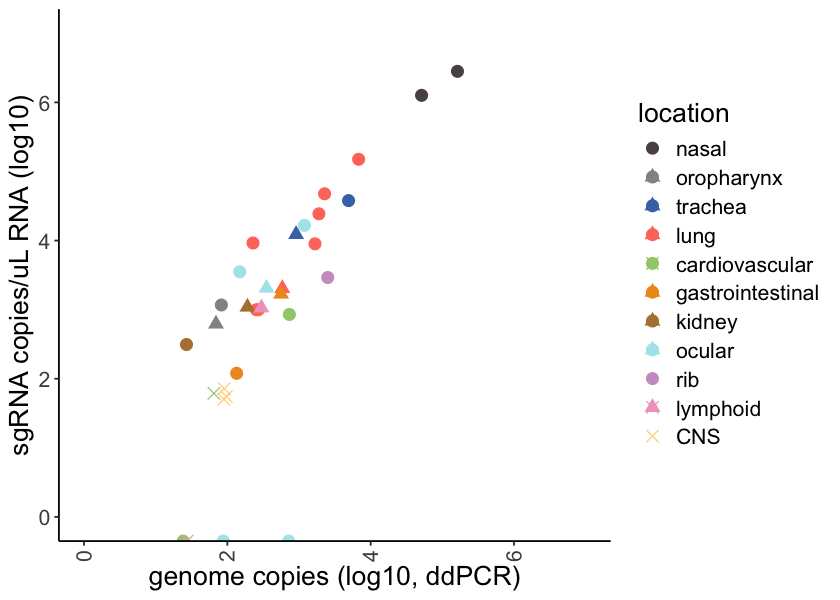

In [14]:
# sgRNA vs. ddPCR results w/ samples that pass/fail
options(repr.plot.width = 7, repr.plot.height = 5)

p0 = ggplot() +
    # pass both consensus and minor variant cutoffs - circle
    geom_point(data= meta %>% 
                    filter(!pacbio_name %in% failures$name &
                           !pacbio_name %in% failures_minor$name), 
                    aes(color = general_location, x=log10(ddPCR),y=log10(sgRNA_copies_uL_RNA)),
              shape = 19, size = 3) + 

    # pass consensus cutoffs - fail minor cutoffs - triangle
    geom_point(data= meta %>% 
                    filter(pacbio_name %in% failures_minor$name & 
                          !pacbio_name %in% failures$name), 
                    aes(color = general_location, x=log10(ddPCR),y=log10(sgRNA_copies_uL_RNA)),
              shape = 17, size = 3) + 

    # fail both analsyes - "X"
    geom_point(data= meta %>%  filter(pacbio_name %in% failures$name), 
                    aes(color = general_location, x=log10(ddPCR),y=log10(sgRNA_copies_uL_RNA)), 
              shape = 4, size = 3) + 
    labs(x='genome copies (log10, ddPCR)', y= "sgRNA copies/uL RNA (log10)") + 
    loc_colScale + 
    ylim(0, 7) + 
    xlim(0, 7)

p0 

#ggsave(p0,
#       filename = glue("{FIG_DIR}/ddpcr.v.sgrna.pdf"),
#       width = 6,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

In [15]:
# calculate correlation
cor.test(meta$ddPCR, meta$sgRNA_copies_uL_RNA)


	Pearson's product-moment correlation

data:  meta$ddPCR and meta$sgRNA_copies_uL_RNA
t = 44.223, df = 30, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9843614 0.9963310
sample estimates:
      cor 
0.9924172 


### What samples pass consensus and minor variant cutoffs?

In [16]:
# List samples that pass both consensus and minor variant cutoffs and provide their sgRNA Cq values 
meta %>% filter(!pacbio_name %in% failures$name & !pacbio_name %in% failures_minor$name) %>% select(detailed_location, Cq)

detailed_location,Cq
<chr>,<dbl>
appendix,33.98
jejunum,37.32
L-bronchus,27.88
L-eye-optic-nerve,29.54
L-inferior-lobe,26.06
L-superior-lobe,33.98
L-ventricle,NA
nasal-placode,21.43
pericardium,34.23


In [17]:
# list samples that pass consensus analyses - but do not minor variant cutoffs - list their sgRNA Cq values:
meta %>% filter(pacbio_name %in% failures_minor$name & !pacbio_name %in% failures$name) %>% select(name, Cq)

name,Cq
<chr>,<dbl>
p45-distal-trachea,30.01
p45-L-kidney,33.83
p45-parotid-salivary-gland,34.73
p45-R-eye-optic-nerve,32.84
p45-R-superior-lobe,32.85
p45-stomach,33.15
p45-thoracic-LN,33.88


In [18]:
# list the samples that fail all cutoffs - provide their sgRNA Cq values:
meta %>% filter(pacbio_name %in% failures$name) %>% select(name, Cq)

name,Cq
<chr>,<dbl>
p45-Basilar-artery,38.13
p45-cervical-spinal-cord,38.69
p45-Dura-matter,38.55
p45-spleen,NA
p45-thoracic-aorta,38.38


# Combining major/minor data into one variant dataframe: 

### PacBio data:

In [19]:
condf = condf1_nsps %>%
            select(all_of(c(column_pull,'majorfreq','majoraa', 'majorcodon'))) %>%
            dplyr::rename('varnt' = 'major', 
                          'varfreq' = 'majorfreq',
                          'varaa' = 'majoraa', 
                          'varcodon' = 'majorcodon') %>%
            mutate(vartype = 'consensus', 
                  con = varnt)


mindf = mindf1_nsps %>% 
    select(all_of(c(column_pull,'minor', 'minorfreq', 'minoraa', 'minorcodon'))) %>%
    drop_na(minor) %>%
    dplyr::rename('varnt' = 'minor', 
                  'varfreq' = 'minorfreq',
                  'varaa' = 'minoraa', 
                  'varcodon' = 'minorcodon',
                  'con' = 'major') %>%
    mutate(vartype = 'minor')

timo_df = rbind(condf, mindf) # timo info for pacbio

timo_df = merge(timo_df, orf_info1, 
      by = c('ntpos','ay119_nt'), all.x = TRUE) %>% 
    filter(gene_id %in% nsps & orf_gene_id %in% c('ORF1a', 'ORF1b') |
           gene_id == orf_gene_id) %>% 
    select(-ay119_aa.x) %>%
    dplyr::rename('ay119_aa'= 'ay119_aa.y') 

### short read data: 

In [20]:
condf2 = sr_condf_nsps %>% 
            select(all_of(c(column_pull,'majorfreq','majoraa', 'majorcodon','pacbio_name'))) %>%
            dplyr::rename('varnt' = 'major', 
                          'varfreq' = 'majorfreq',
                          'varaa' = 'majoraa', 
                          'varcodon' = 'majorcodon') %>%
            mutate(vartype = 'consensus', 
                   con = varnt)

mindf2 = sr_mindf_nsps %>% 
            select(all_of(c(column_pull,'minor', 'minorfreq', 'minoraa', 'minorcodon','pacbio_name'))) %>%
            drop_na(minor) %>%
            dplyr::rename('varnt' = 'minor', 
                          'varfreq' = 'minorfreq',
                          'varaa' = 'minoraa', 
                          'varcodon' = 'minorcodon',
                          'con' = 'major') %>%
            mutate(vartype = 'minor')

timo_df2 = rbind(condf2, mindf2)

timo_df2 = merge(timo_df2, orf_info2, 
                  by = c('ntpos','ay119_nt'), all.x = TRUE) %>% 
            filter(gene_id %in% nsps & orf_gene_id %in% c('ORF1a', 'ORF1b') |
               gene_id == orf_gene_id) %>% 
            select(-ay119_aa.x) %>%
            dplyr::rename('ay119_aa'= 'ay119_aa.y')

In [21]:
vardf = timo_df %>% 
            filter(varnt != '-' & con !='-') %>% # ignoring deletions for now
        unique()

In [22]:
vardf2 = timo_df2 %>% 
            filter(varnt != '-' & con !='-') %>%
            mutate(name = pacbio_name) %>% # change name for merging w/ pb data
    unique()

In [23]:
# here filter out the tongue and pericardium - make into pacbio like df: 
temp = vardf2 %>% filter(name %in% c('p45_tongue','p45_pericardium')) %>% select(all_of(colnames(vardf)))
vardf = rbind(vardf, temp) # bind because we do not have pacbio data for these samples

In [24]:
vardf2 = vardf2 %>% 
            filter(varnt != ay119_nt) %>%  # only variants in the sr dataframe
            select(name, varnt, ntpos, gene_id, varnt, varfreq, totalcount) %>% 
    dplyr::rename("timo_varfreq" = 'varfreq',
                  "totalcount_timo" = "totalcount")

In [25]:
# combine short read and long read data: 
prefilt_df = merge(vardf, vardf2, by = c('name','ntpos','gene_id','varnt'), all.x = TRUE)
prefilt_df$timo_varfreq[is.na(prefilt_df$timo_varfreq)] = 0

# Filtering the variant data: 
**"keep_var" flag**:    
- Consensus: totalcount >= cov_requirement    
- Minor: totalcount >= minor_cov_stringent, varfreq >= minor_freq    

**In short flag**: present in short > 0 (no coverage or freq min) [Pass or Fail]    

**Short cov flag**: present and totalcount >= timo_cov    
**Combined_flag** = keep var + in short + short cov    

The variant MUST be present in short-read data if there is enough read depth.     
The variant MUST pass PacBio cutoffs if the region wasn't seq'd in the short-read data    
The variant MUST pass the short-read cutoffs if it doesn't pass the stringent cutoffs of the PacBio data.    

Pass + Pass + Pass = Passes all flags and checks    
Pass + Pass + Fail = Passes PacBio cutoffs, present in short-read data, does not pass short-read rd cutoff    
Pass + Fail + NA = Passes all PacBio cutoffs, no read depth in short-read data at given nt position suggesting a region that is poorly sequenced    
Fail + Pass + Pass = Fails stringent PacBio cutoffs but passes the short-read cutoffs    

In [26]:
prefilt_df = prefilt_df %>%
            # Pass - if consensus and above totalcount requirement
            mutate(keep_var = ifelse(vartype == 'consensus' & 
                                     totalcount >= cov_requirement,'PASS',
            # Pass - if minor, above stringent cutoff for rd and above minor freq cutoff. Else - fail
                    ifelse(vartype == 'minor' & 
                           totalcount >= minor_cov_stringent & 
                           varfreq >= minor_freq,
                        'PASS', 'FAIL')),
                # if above in short: 
                in_short = ifelse(timo_varfreq > 0,'PASS','FAIL'), # if it is in the short read data at ALL 
                short_cov = ifelse(totalcount_timo >= timo_cov, "PASS", "FAIL"),
                combined_flag = glue("{keep_var}_{in_short}_{short_cov}")# above the given freq
               ) 

In [27]:

filt_df = prefilt_df %>% filter(combined_flag %in% c("PASS_PASS_FAIL", 'PASS_PASS_PASS','PASS_FAIL_NA') &
                                !gene_id %in% c('3\'UTR', '5\'UTR') |
                               
                               combined_flag == "FAIL_PASS_PASS" & 
                               totalcount >= minor_cov_stringent &
                               varfreq >= minor_freq_lenient & 
                               varfreq <= 0.50 &
                               #totalcount_timo >= timo_cov & 
                               totalcount_timo >= minor_cov_stringent & 
                               timo_varfreq >= timo_minorfreq & 
                               !gene_id %in% c('3\'UTR', '5\'UTR')) %>% 
            mutate(var = glue('{gene_id}: {ntpos}{varnt}')) %>%
            unique()

# Consensus mutant map and read depth: 

In [28]:
temp = filt_df %>% 
    ungroup() %>%
    filter(vartype == 'consensus' & 
            varnt != ay119_nt & 
           !name %in% failures$name) %>%
    select(name, ntpos, gene_id, varnt, ay119_nt, aapos, varaa, ay119_aa) %>%
    unique() %>%
    group_by(ntpos, gene_id, varnt, ay119_nt, aapos, varaa, ay119_aa) %>%
    drop_na(varaa) %>%
    tally() %>% arrange(ntpos) %>%
    mutate(ntvar = glue("{gene_id}: {ay119_nt}{ntpos}{varnt} ({n}) ({ay119_aa}{aapos}{varaa})"),
          mutation_type = ifelse(varaa == ay119_aa, 'syn','nonsyn'))

temp %>% select(ntpos) %>% unique() %>% arrange(ntpos)

Adding missing grouping variables: `gene_id`, `varnt`, `ay119_nt`, `aapos`, `varaa`


gene_id,varnt,ay119_nt,aapos,varaa,ntpos
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
nsp2,T,C,419,A,2062
nsp5,T,C,132,L,10449
nsp14,T,G,191,D,18612
S,C,G,19,T,21618
S,G,A,417,R,22812
S,C,T,445,A,22896
S,T,G,446,V,22899
S,T,A,453,F,22920
S,A,G,476,S,22988


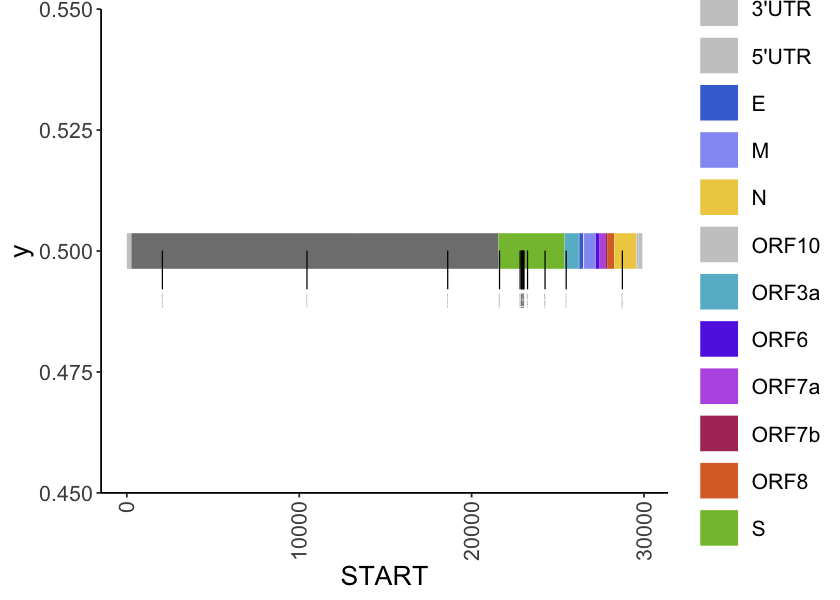

In [29]:
p1 = ggplot(gene_info %>% filter(!NAME %in% nsps) , aes(x = START, xend = END, fill = NAME)) +
    geom_segment(aes(y= 0.5, yend = 0.5, color = NAME), linewidth = 10) + 
    geom_feature(data = temp,
        aes(x = ntpos, y = 0.5),  size = 1, feature_height = unit(-8, 'mm'), color = 'black') + 
    geom_feature_label(data = temp,
        aes(x = ntpos, y = 0.5, label = ntvar), feature_height = unit(-9, 'mm'), angle = 90, size = 13, color = 'black') +
    gene_colScale 
p1


#ggsave(p1,
#       filename = glue("{FIG_DIR}/consensus.map.{minor_freq}.pdf"),
       #width = 12,
       #height = 4, limitsize=FALSE, useDingbats = FALSE)

name,gene_id,ntpos,totalcount
<chr>,<chr>,<int>,<int>
p45_thoracic_LN,nsp14,18612,0
p45_thoracic_LN,S,21618,2


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”


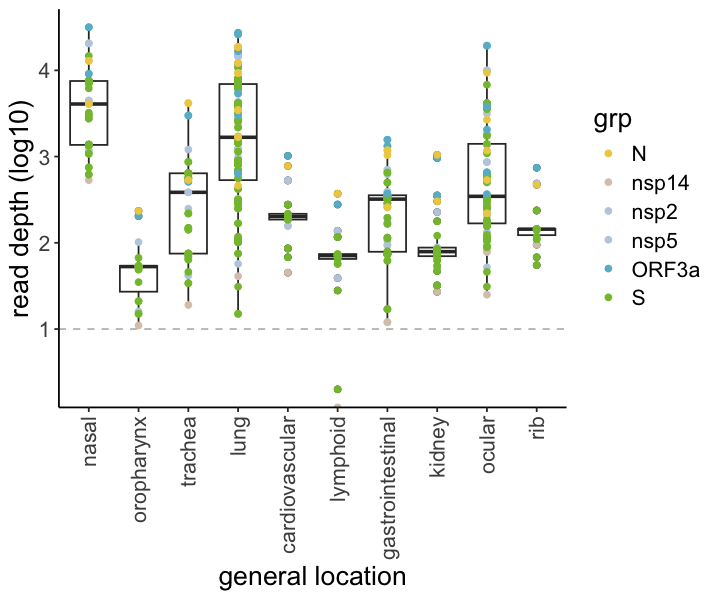

In [30]:
options(repr.plot.width = 6, repr.plot.height = 5)

p3 = timo_df %>%
    filter(gene_id == 'S' & aapos == 486  & 
           !name %in% failures$name | # not a consensus position so not in the 'temp' df
            ntpos %in% temp$ntpos & !name %in% failures$name) %>%
    ggplot(., aes(x = general_location, y= log10(totalcount))) + 
        geom_hline(yintercept = log10(10), linetype = 2, color = 'gray') + 
        geom_boxplot()+ 
        geom_point(aes(color = gene_id)) +
        gene_colScale + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(y= 'read depth (log10)', x= 'general location', color = 'gene id')

timo_df %>%
    filter(ntpos %in% temp$ntpos & !name %in% failures$name & totalcount < 10) %>%
    select(name, gene_id, ntpos, totalcount)

p3


#ggsave(p3,
#       filename = glue("{FIG_DIR}/consensus.rd.positions.{minor_freq}.pdf"),
#       width = 5,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

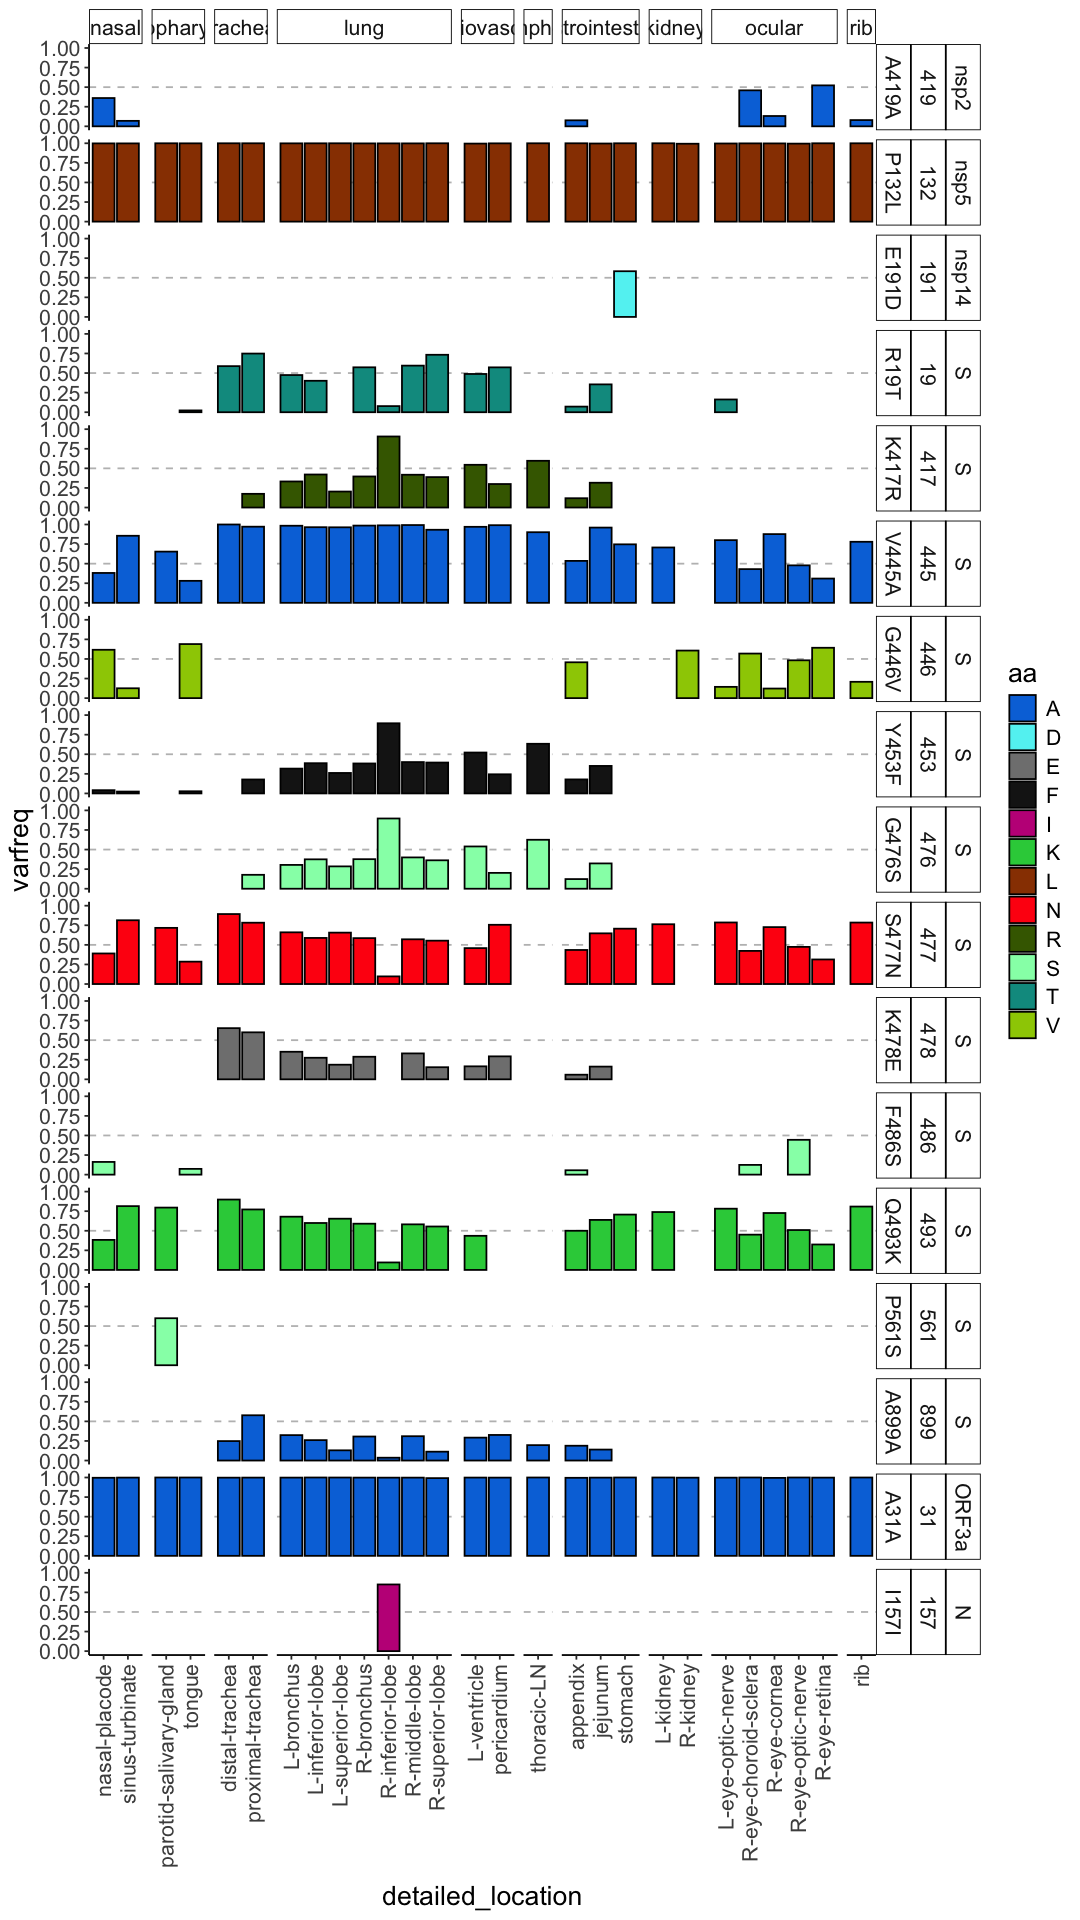

In [31]:
timo_df$gene_id = factor(timo_df$gene_id, levels = gene_ord_list)
filt_df$gene_id = factor(filt_df$gene_id, levels = gene_ord_list)

options(repr.plot.width = 9, repr.plot.height = 16)

p4 = filt_df %>% 
                filter(gene_id == 'S' & aapos == 486 | 
                       !name %in% failures$name & 
                    !gene_id %in% c('3\'UTR', '5\'UTR') & 
                    varnt != ay119_nt &                    
                   ntpos %in% temp$ntpos) %>% 
    unique() %>%
    ggplot(., aes(x= detailed_location, y = varfreq, fill = varaa)) + 
        geom_hline(yintercept = 0.50, linetype = 2, color = 'gray') +
        geom_col(color = 'black') + 
        aa_colScale_fill + 
        facet_grid(gene_id + aapos + glue("{ay119_aa}{factor(aapos)}{varaa}") ~general_location, scales = 'free_x', space = 'free') + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
    p4

#ggsave(p4,
#       filename = glue("{FIG_DIR}/consensus.positions.freq.{minor_freq}.pdf"),
#       width = 8,
#       height = 15, limitsize=FALSE, useDingbats = FALSE)

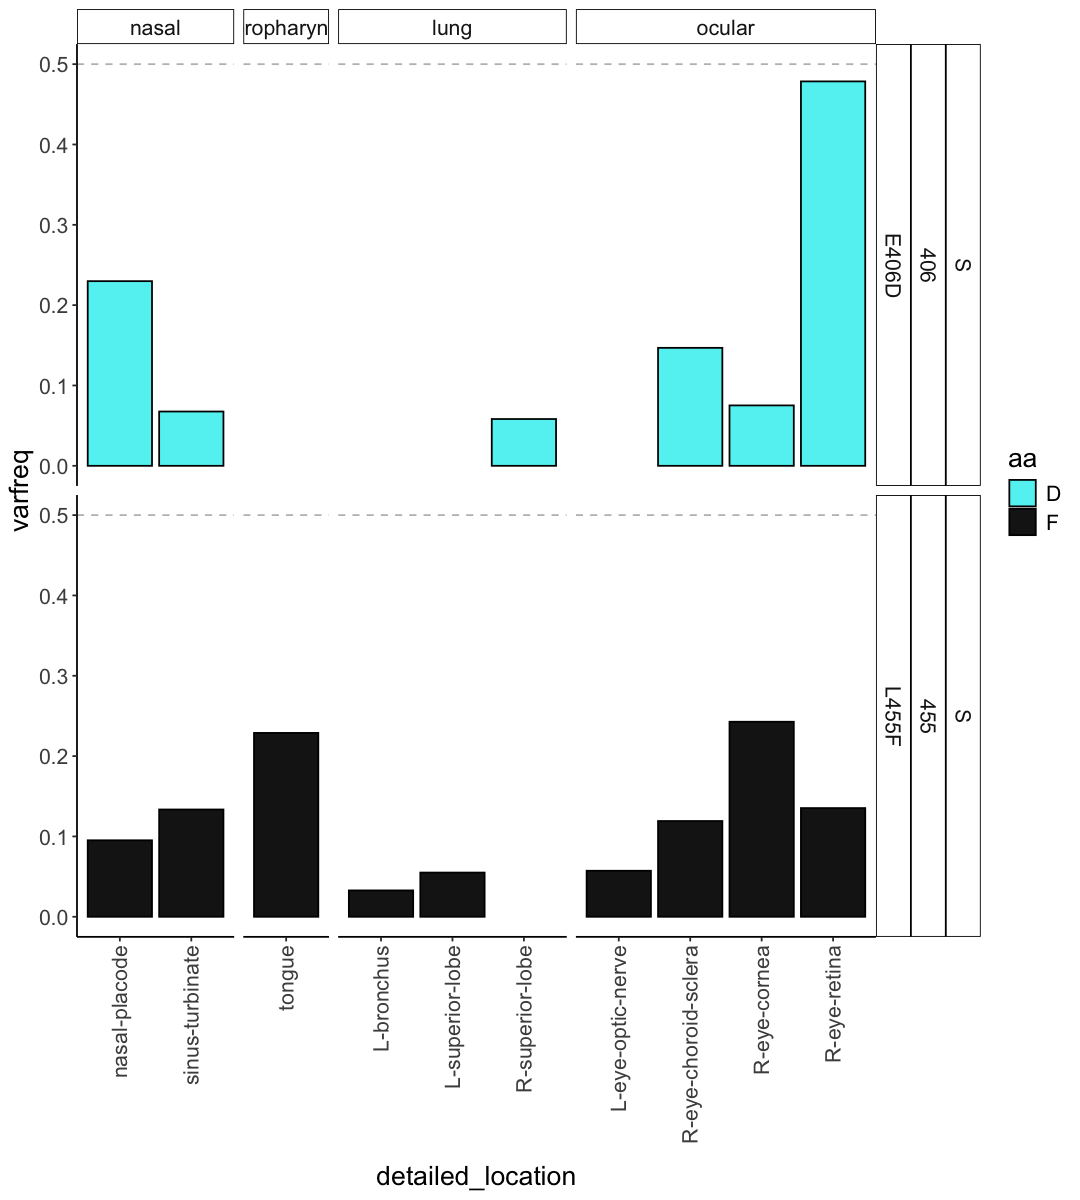

In [32]:
options(repr.plot.width = 9, repr.plot.height = 10)

p4 = filt_df %>% filter(gene_id == 'S' & aapos %in% c(406, 455, 573, 1267) & 
                       !name %in% failures$name & 
                    !gene_id %in% c('3\'UTR', '5\'UTR') & 
                    varnt != ay119_nt) %>% 
    unique() %>%
    ggplot(., aes(x= detailed_location, y = varfreq, fill = varaa)) + 
        geom_hline(yintercept = 0.50, linetype = 2, color = 'gray') +
        geom_col(color = 'black') + 
        aa_colScale_fill + 
        facet_grid(gene_id + aapos + glue("{ay119_aa}{factor(aapos)}{varaa}") ~general_location, scales = 'free_x', space = 'free') + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
p4

#ggsave(p4,
#       filename = glue("{FIG_DIR}/extra.isolates.positions.freq.{minor_freq}.pdf"),
#       width = 6,
#       height = 8, limitsize=FALSE, useDingbats = FALSE)

# Variant analyses: 
- Bray Curtis
- Richness by gene region and tissue location
- Divrgence and dn/ds

## Bray-Curtis:

Pull ntpos where a minor was present in at least 1 sample (can be a major in another sample)

In [33]:
# generating df for the network stuff: 
majmin_df = filt_df %>% 
            filter(!name %in% failures_minor$name) %>%
            select(name, var, varfreq) %>%
            unique() %>% 
            pivot_wider(names_from = "var", values_from = 'varfreq', values_fill = 0) %>% 
            unique()

In [34]:
# Filter for minor var locations
min_wide = filt_df %>% 
            filter(vartype == 'minor' & 
                   varnt != ay119_nt & 
                   !name %in% failures_minor$name) %>% 
            select(name, var, varfreq) %>%
            unique() 

# use those minor vars to pull major information:
maj_wide = filt_df %>% 
            filter(vartype != 'minor' & 
                   !name %in% failures_minor$name &
                   varnt != ay119_nt &
                   var %in% min_wide$var) %>% 
            select(name, var, varfreq) %>%
            unique() 

# combine them into two and add zeros to the samples that officially do not have that data:
total_wide = rbind(min_wide, maj_wide) %>% 
                unique() %>%
                pivot_wider(names_from = "var", values_from = 'varfreq', values_fill = 0) %>% 
                unique()

In [35]:
c1 =  total_wide %>% 
        pivot_longer(!name, names_to = 'var', values_to = 'minorfreq') # changing to 'minorfreq' even though some will be major

compare_var = merge(c1, c1, by = c('var'), all = TRUE)

# it has to be a minor variant in at least one sample being compared
# it can't be a major variant in both locations
compare_var = compare_var %>% filter(minorfreq.x > 0 & minorfreq.x < 0.50 | minorfreq.y > 0 & minorfreq.y < 0.50) 


In [36]:
bray_curt = compare_var %>%
    group_by(name.x, name.y) %>%
    mutate(S.x = sum(minorfreq.x),
          S.y = sum(minorfreq.y)) %>%
    ungroup() %>%
    rowwise() %>%
    mutate(lowest_freq = min(minorfreq.x, minorfreq.y)) %>%
    ungroup() %>%
    group_by(name.x, name.y) %>%
    mutate(C = sum(lowest_freq)) %>%
    ungroup() %>%
    select(name.x, name.y, S.x, S.y, C) %>%
    unique() %>%
    rowwise() %>%
    mutate(BC = 1 - ((2*(C))/(S.x + S.y))) %>%
    ungroup() %>%
    group_by(name.x) %>%
    mutate(order_sum = sum(BC)) %>%
    ungroup()

reorder_list = (bray_curt %>% arrange(order_sum) %>% select(name.x) %>% unique())$name.x
bray_curt$name.x = factor(bray_curt$name.x, levels = reorder_list)
bray_curt$name.y = factor(bray_curt$name.y, levels = reorder_list)

bray_curt = bray_curt %>% arrange(order_sum)
reord_name = unique(bray_curt$name.x)

avg_filt = mean((bray_curt %>% filter(name.x != name.y))$BC)
med_filt = median((bray_curt %>% filter(name.x != name.y))$BC)


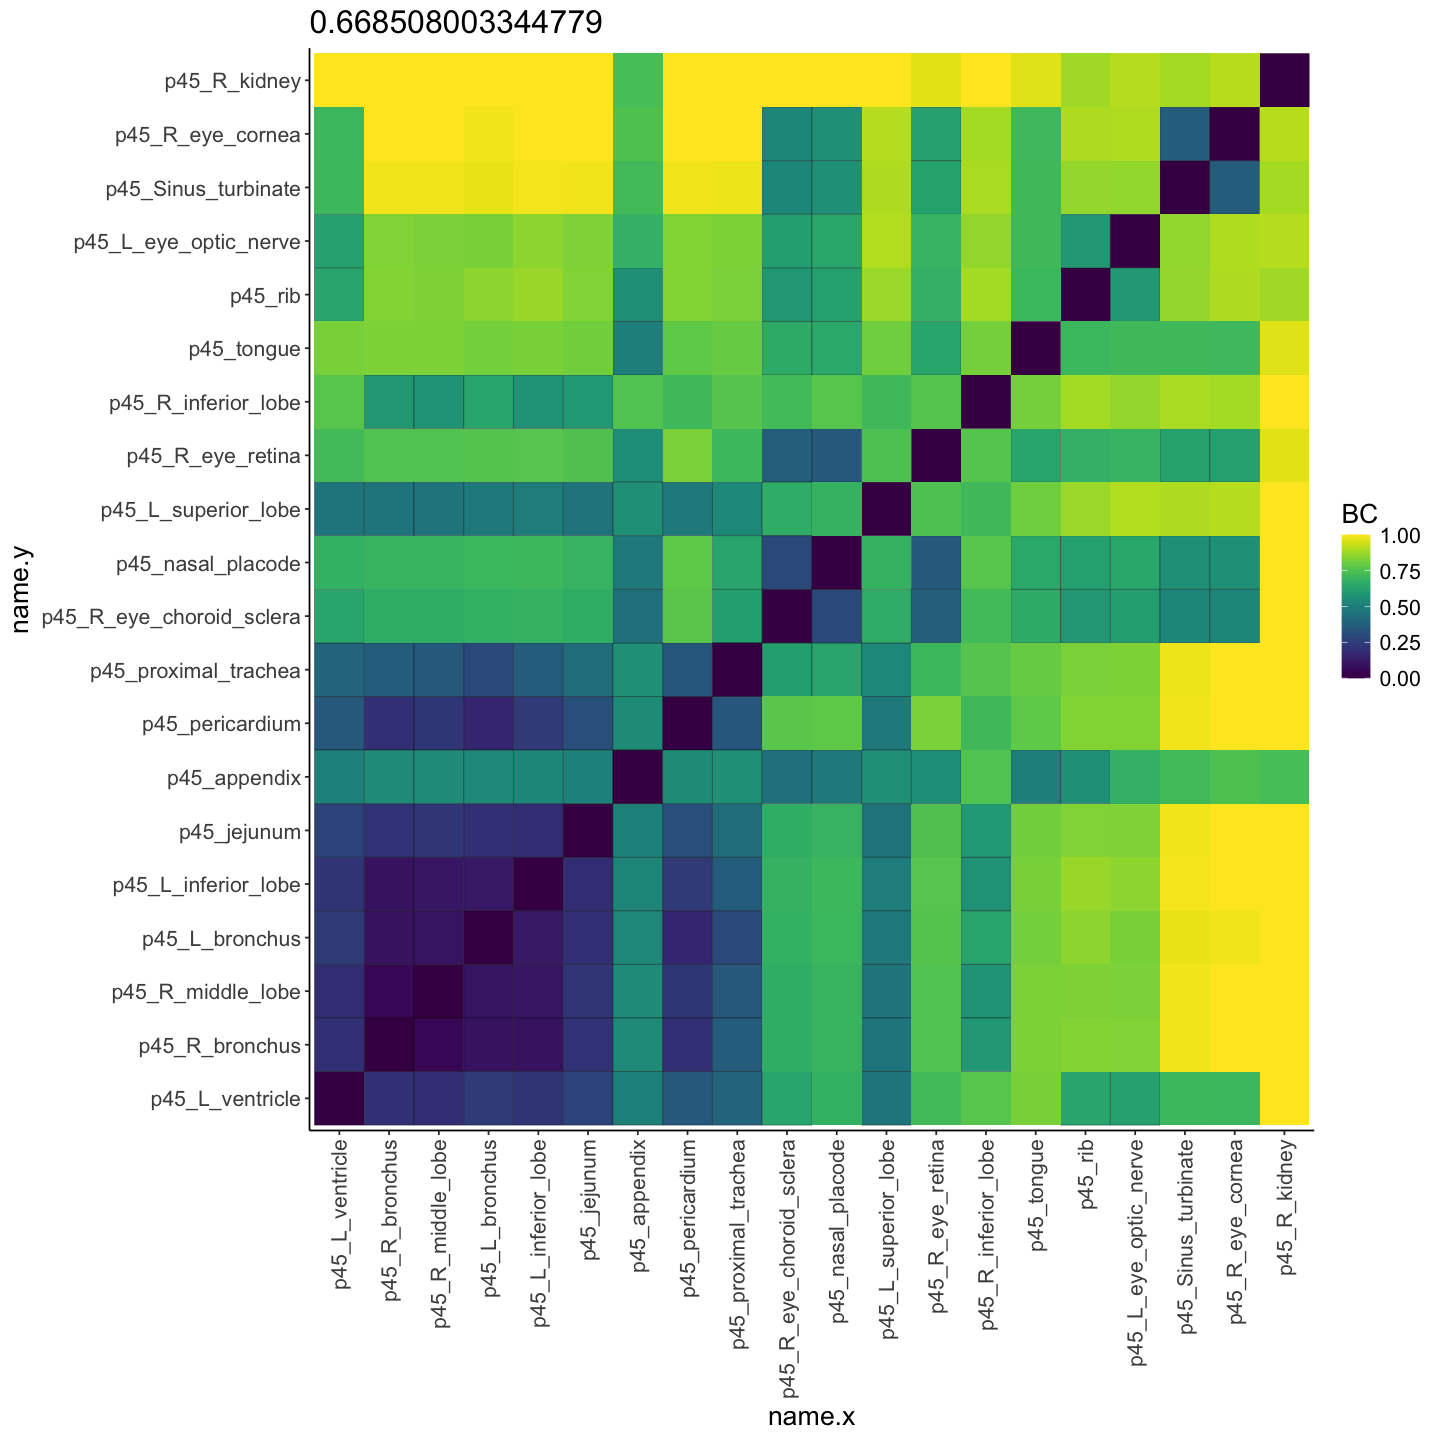

In [37]:
options(repr.plot.width = 12, repr.plot.height = 12)

p8 = ggplot() + 
    geom_tile(data = bray_curt %>% filter(BC < avg_filt), aes(x=name.x, name.y, fill = BC), color = 'black') +
    geom_tile(data = bray_curt %>% filter(BC >= avg_filt), aes(x=name.x, name.y, fill = BC)) +
    scale_fill_viridis(limits = c(0, 1.0)) + 
    labs(title = avg_filt)

p8

#ggsave(p8,
#       filename = glue("{FIG_DIR}/bray.curtis.minors.{minor_freq}.pdf"),
#       width = 8,
#       height = 7, limitsize=FALSE, useDingbats = FALSE)

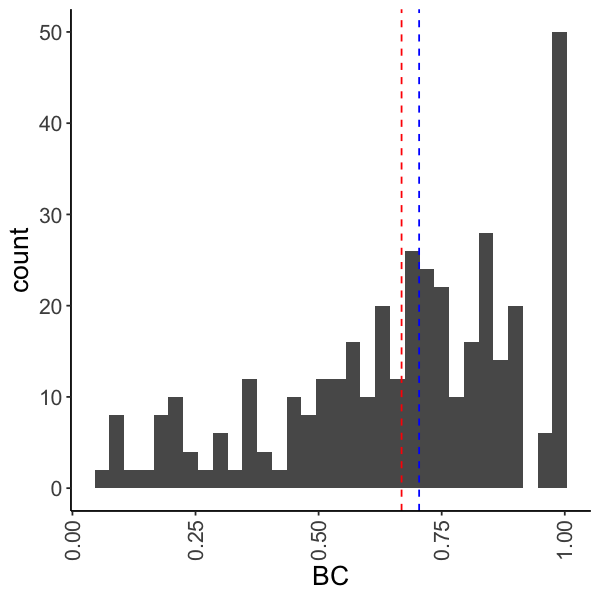

In [38]:
options(repr.plot.width = 5, repr.plot.height = 5)

p5 = bray_curt %>% filter(name.x != name.y) %>% 
    ggplot(., aes(x=BC)) +
        geom_histogram(binwidth = 0.03) + 
        geom_vline(xintercept = avg_filt, linetype = 2, color = 'red') + 
        geom_vline(xintercept = med_filt, linetype =2, color = 'blue') 
p5

In [39]:
# getting meta together for network
nodes= meta %>% 
        select(pacbio_name, general_location, detailed_location) %>% 
        filter(!pacbio_name %in% failures_minor$name & 
               pacbio_name %in% bray_curt$name.x)

links = bray_curt %>% select(name.x, name.y, BC) %>% filter(name.x != name.y) %>% filter(BC < avg_filt)

colnames(links) = c('from','to','weight')

nrow(nodes) == length(unique(nodes$pacbio_name))

nrow(links) == nrow(unique(links[,c("from", "to")]))

net <- graph_from_data_frame(d=links, vertices=nodes)

[1] TRUE

[1] TRUE

Warning message in cluster_edge_betweenness(net):
“At vendor/cigraph/src/community/edge_betweenness.c:498 : Membership vector will be selected based on the highest modularity score.”
Warning message:
“`dendPlot()` was deprecated in igraph 2.0.0.
ℹ Please use `plot_dendrogram()` instead.”


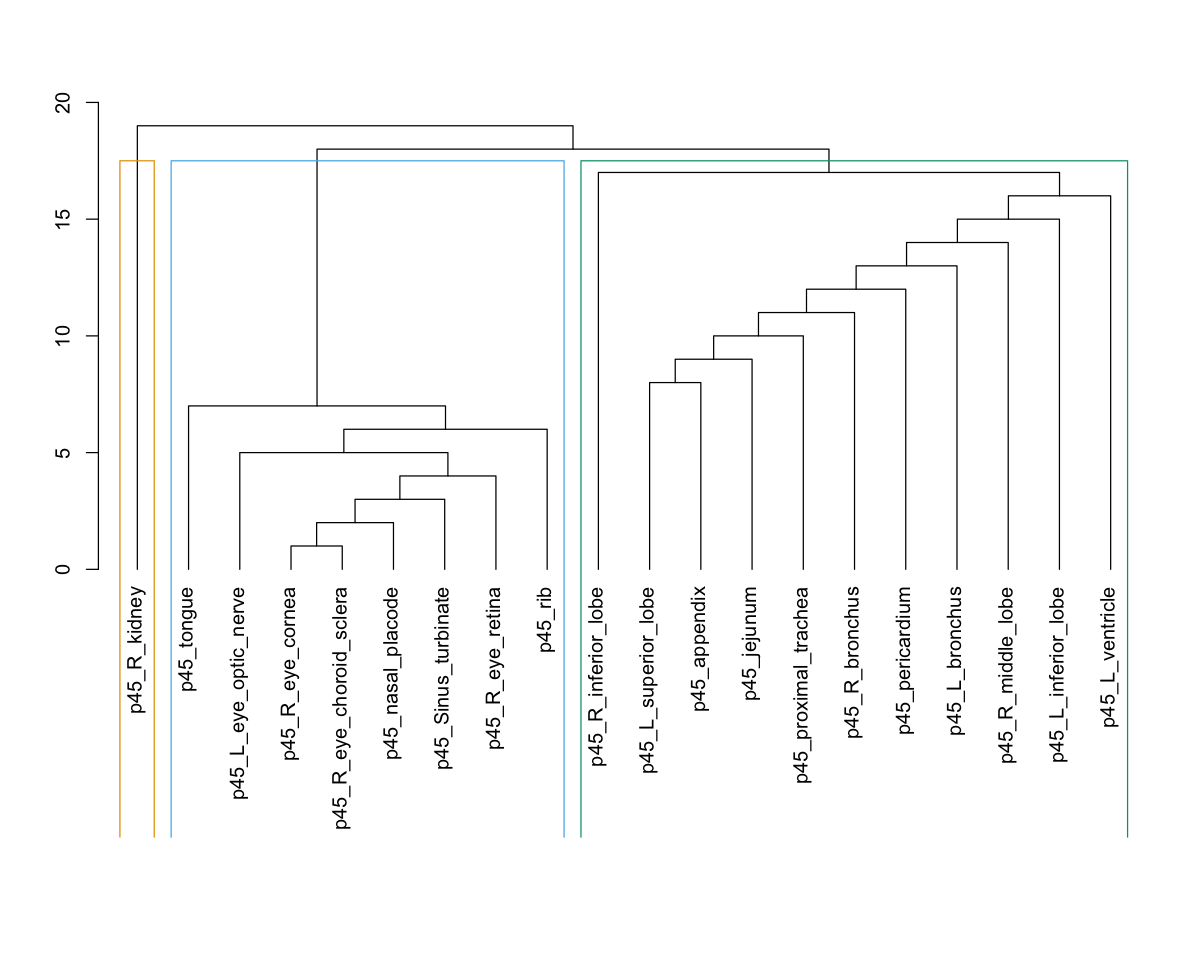

In [40]:
options(repr.plot.width = 10, repr.plot.height = 8)

ceb <- cluster_edge_betweenness(net) 

dendPlot(ceb, mode="hclust")

In [41]:
cluster_df = data.frame()
for (i in 1:length(ceb)){
    df = cbind(as.data.frame(ceb[[i]]), i)
    colnames(df) = c('name', 'cluster')
    cluster_df = rbind(cluster_df, df)
}
cluster_df = cluster_df %>%
            mutate(cluster_type = ifelse(cluster > 3, 'other', cluster))

bray_curt = merge(bray_curt, cluster_df, by.x = c('name.x'), by.y = c('name'))
bray_curt = merge(bray_curt, cluster_df, by.x = c('name.y'), by.y = c('name'))

## Stats for clusters:

#### Cluster 1:

In [42]:
# cluster 1
mean((bray_curt %>% filter(cluster.x == cluster.y & cluster.x == 1))$BC)
sd((bray_curt %>% filter(cluster.x == cluster.y & cluster.x == 1))$BC)


[1] 0.3592156

[1] 0.219074

#### Cluster 2: 

In [43]:
# cluster 2
mean((bray_curt %>% filter(cluster.x == cluster.y & cluster.x == 2))$BC)
sd((bray_curt %>% filter(cluster.x == cluster.y & cluster.x == 2))$BC)

[1] 0.5480554

[1] 0.2534093

#### Across Cluster 1 & 2

In [44]:
# across cluster 1/2
mean((bray_curt %>% filter(cluster.x != cluster.y))$BC)
sd((bray_curt %>% filter(cluster.x != cluster.y))$BC)

[1] 0.820058

[1] 0.1361752

### Plots 

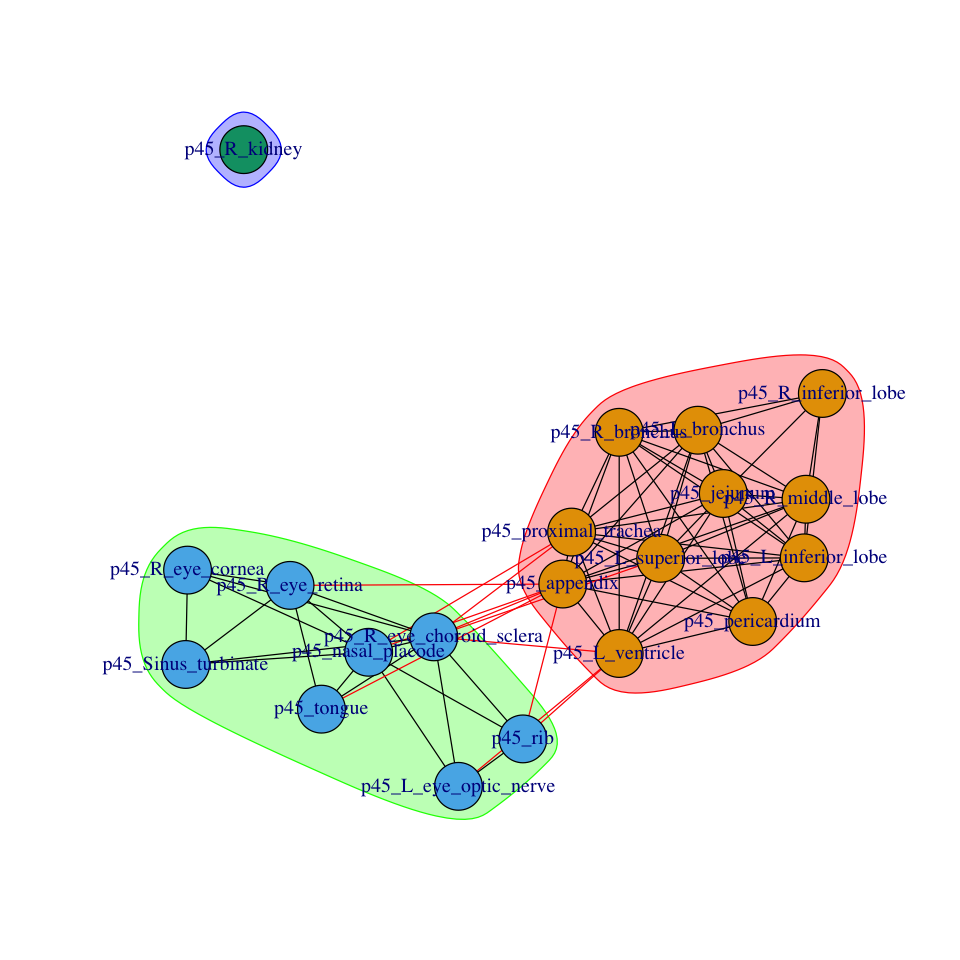

In [45]:
options(repr.plot.width = 8, repr.plot.height = 8)

cfg <- cluster_fast_greedy(as.undirected(net))

plot(cfg, as.undirected(net))

Warning message in cluster_edge_betweenness(as.undirected(net)):
“At vendor/cigraph/src/community/edge_betweenness.c:498 : Membership vector will be selected based on the highest modularity score.”


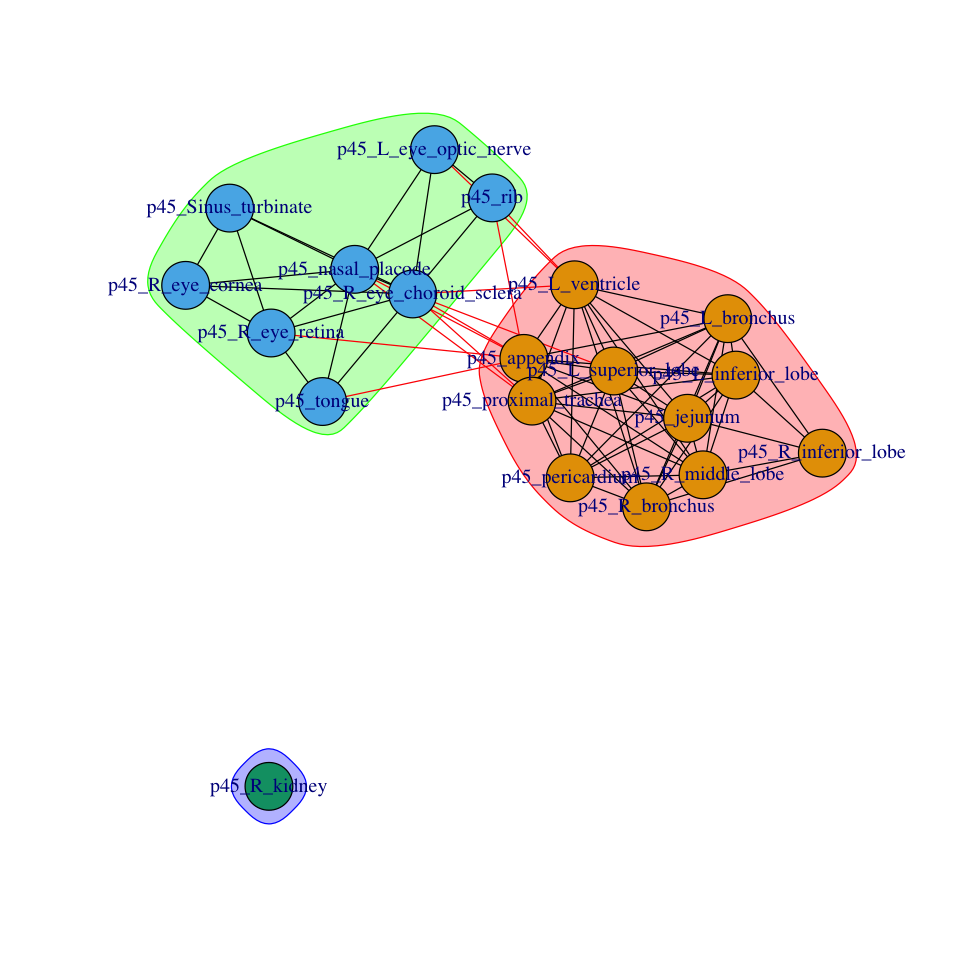

In [46]:
options(repr.plot.width = 8, repr.plot.height = 8)

cfg <- cluster_edge_betweenness(as.undirected(net))

plot(cfg, as.undirected(net))

In [47]:
body_colors = as.vector(kelly(21))[3:4]
names(body_colors) = c('body','head')
body_colScale_fill <- scale_fill_manual(name = "region",values = body_colors)
body_colScale <- scale_colour_manual(name = "region",values = body_colors)

null device 
          1

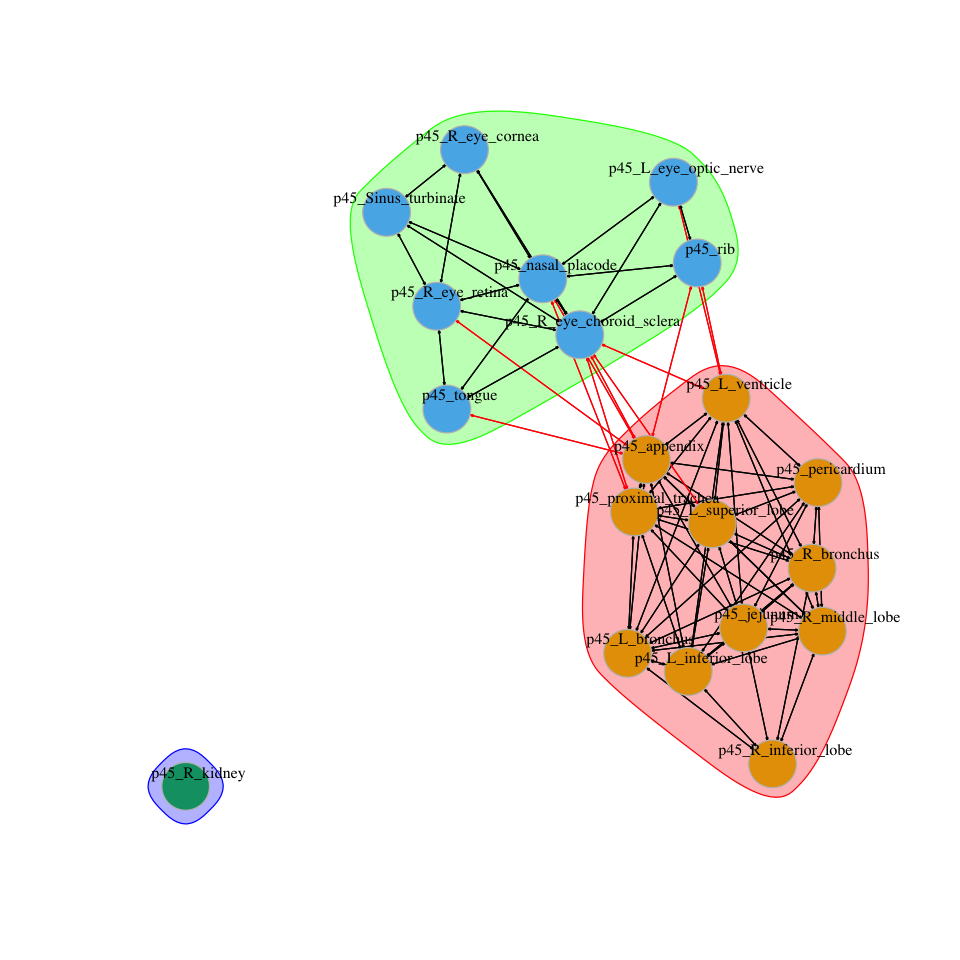

In [48]:
# FIGURE 5A:
options(repr.plot.width = 8, repr.plot.height = 8)

#pdf(file = glue("{FIG_DIR}/BC.network.minorvar.{minor_freq}.pdf"),   # The directory you want to save the file in
#    width = 10, # The width of the plot in inches
#    height = 10) # The height of the plot in inches

plot(cfg, net, edge.arrow.size=.1,
    edge.arrow.size=.5, 
     vertex.size=15, 
     vertex.frame.color="gray", 
     vertex.label.color="black", 
     vertex.label.cex=0.8, 
     vertex.label.dist=0.8,
     vertex.color= body_colors[as.numeric(as.factor(vertex_attr(net, "major_location")))]) 

dev.off()


membership = cbind(cfg$membership, cfg$name)
colnames(membership) = c('membership','name')

# Determining variants unique to BC clusters:

In [49]:
majmin_df = filt_df %>% # pull all variants (major and minor)
                filter(varnt != ay119_nt & 
                       !name %in% failures_minor$name) %>%
                select(name, var, varfreq) %>%
                unique() %>% 
                pivot_wider(names_from = "var", values_from = 'varfreq', values_fill = 0) %>% # 0s indicate no variant found in the sample
                unique()

In [50]:
# Look at distance using the above filtered data: 
temp = majmin_df %>% as.data.frame() # majmin is the dataframe filtered to have no seq failures 
rownames(temp)  = temp$name # make names the rownames - cols vars - cells = frequency
temp = temp %>% select(-name) %>% t() # remove name to calculate


d = dist(temp, method = 'manhattan', diag=T, upper=T) # calculate distance using the frequency
fit <- cmdscale(d, eig=TRUE, k=2) 
fit2 = as.data.frame(fit$points)
fit2$var = rownames(temp)

dend0 = hclust(d)
temp = dend0$labels %>% as.data.frame() %>%
    mutate(id = row_number())
colnames(temp) = c('labels', 'id')

temp = temp[match(dend0$order, temp$id),]

reorderit = c(temp$labels) # labels that are commonly together

In [51]:
majmin_long = majmin_df %>% # make the var df long (filled with zero's)
        pivot_longer(!c('name'), names_to = 'var',values_to = 'freq') %>%
    unique()


majmin_long$var = factor(majmin_long$var, levels = reorderit)  # reorder variants commonly found together

majmin_long = majmin_long %>% group_by(var) %>% mutate(mean_freq = mean(freq)) %>% ungroup() # calc mean to use for arranging

reorder_df = majmin_long %>% select(name, mean_freq) %>% unique() %>% arrange(mean_freq)

majmin_long$name = factor(majmin_long$name, levels = reord_name)


majmin_long = merge(majmin_long, meta, # merge with metadata
                   by.x = c('name'),
                   by.y = c('pacbio_name'),
                    all.x = TRUE)

majmin_long = merge(majmin_long, membership, by = c('name'), all.x = TRUE) # combine bc membership groups

In [52]:
find_sets = majmin_long %>% 
                mutate(type = ifelse(freq >= 0.50, 'high','low')) %>%
                filter(freq > 0) %>% # filter for var with freqs
                group_by(var) %>% # group by the variant
                add_tally(name = 'var_count') %>% # how many samples have the count
                ungroup() %>%
                filter(var_count > 1) %>%  # filter for variants found in multiple samples
                group_by(var,type) %>%
                add_tally(name = 'type_count') %>% 
                ungroup() %>%
                select(var, var_count, membership, type, type_count) %>% # group by how many samples within the membership
                unique() %>%
                group_by(var) %>%
                add_tally(name = 'membership_count') %>%
                ungroup() %>%
            mutate(FILTER = ifelse(type == 'high' & var_count == type_count, 'FILTER', 'KEEP'))

find_sets = find_sets %>% filter(FILTER != 'FILTER') %>% arrange(-var_count)

In [53]:
set1 = find_sets %>% filter(membership == 1) %>% arrange(-var_count, membership_count)
set2 = find_sets %>% filter(membership == 2) %>% arrange(-var_count,membership_count)
set3 = find_sets %>% filter(membership == 3) %>% arrange(-var_count,membership_count)

### Number of samples in clusters 1 and 2:

In [54]:
glue("cluster 1: {as.data.frame(membership) %>% filter(membership == 1) %>% nrow()}")
glue("cluster 2: {as.data.frame(membership) %>% filter(membership == 2) %>% nrow()}")


cluster 1: 11

cluster 2: 8

In [55]:
only_s1 = setdiff(set1$var, set2$var) # in set 1
only_s2 = setdiff(set2$var, set1$var) # in set 2
shared_s1s2 = intersect(set1$var, set2$var) # in set 3
other = setdiff(find_sets$var, c(only_s1, only_s2))
var_order = c(only_s1, only_s2, other)

In [56]:
majmin_long = majmin_long %>% 
    filter(var %in% find_sets$var) %>% 
    mutate(temp_var = var) %>%
    separate(temp_var, sep = ":", c('gene_id', 'temp_var'))

### Mutations only found in cluster 1: 

In [57]:
only_s1

[1] "S: 22812G"      "S: 22988A"      "S: 24259C"      "S: 22994G"     
[5] "nsp4: 8905T"    "nsp12b: 13887T" "S: 21639T"

### Mutations only found in cluster 2: 

In [58]:
only_s2

[1] "S: 22780T"     "S: 23012C"     "nsp1: 292T"    "nsp2: 913T"   
 [5] "S: 22845G"     "S: 23302T"     "nsp2: 2058C"   "nsp3: 4201T"  
 [9] "nsp13: 16391T" "S: 23040T"     "ORF6: 27263T"  "N: 29095T"

### Order of variants for heatmap:

In [59]:
var_order

[1] "S: 22812G"      "S: 22988A"      "S: 24259C"      "S: 22994G"     
 [5] "nsp4: 8905T"    "nsp12b: 13887T" "S: 21639T"      "S: 22780T"     
 [9] "S: 23012C"      "nsp1: 292T"     "nsp2: 913T"     "S: 22845G"     
[13] "S: 23302T"      "nsp2: 2058C"    "nsp3: 4201T"    "nsp13: 16391T" 
[17] "S: 23040T"      "ORF6: 27263T"   "N: 29095T"      "S: 22896C"     
[21] "S: 22992A"      "S: 23039A"      "S: 22920T"      "nsp2: 2003T"   
[25] "S: 21618C"      "S: 22035T"      "S: 22995T"      "S: 22899T"     
[29] "S: 22927T"      "nsp2: 2062T"    "S: 23027C"      "N: 29508A"     
[33] "nsp13: 16293T"  "S: 23019C"      "ORF6: 27213T"   "nsp8: 12514A"  
[37] "S: 23525T"      "nsp7: 12041T"   "nsp8: 12624T"   "nsp3: 8290T"   
[41] "nsp8: 12400T"   "nsp10: 13390A"  "nsp12b: 15521A" "nsp13: 16920T" 
[45] "nsp13: 16925G"

#### Prep the order of gene ids, variants, and sample names for heatmap:

In [60]:
majmin_long$gene_id = factor(majmin_long$gene_id, levels = gene_ord_list) 
majmin_long$var = factor(majmin_long$var, levels = var_order)
majmin_long$detailed_location = factor(majmin_long$detailed_location, levels = detailed_orderlist)

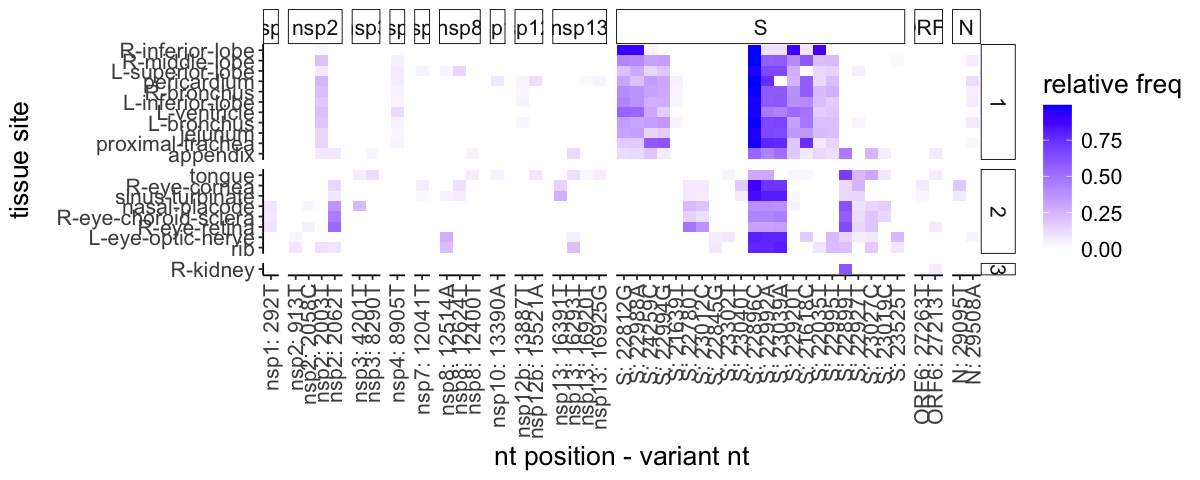

In [61]:
options(repr.plot.width = 10, repr.plot.height = 4)
p1 = majmin_long %>% 
    ggplot(., aes(x= var, y = detailed_location, fill = freq)) + 
        geom_tile() + 
        scale_fill_gradient(low = 'white', high='blue') + 
        labs(y = "tissue site", x="nt position - variant nt", fill = 'relative freq') + 
        facet_grid(factor(membership)~ gene_id, scales = 'free', space = 'free')
p1

#ggsave(p1,
#       filename = glue("{FIG_DIR}/reduced.vars.{minor_freq}.pdf"),
#       width = 15,
#       height = 7, limitsize=FALSE, useDingbats = FALSE)

#### What variants were found in all 11 samples of cluster 1 and 8 samples of cluster 2?

In [62]:
majmin_long %>% filter(var %in% only_s1 & membership == 1 & freq > 0) %>%
    group_by(var) %>%
    tally() %>%
    mutate(percentage = n/11)


majmin_long %>% filter(var %in% only_s2 & membership == 2 & freq > 0) %>%
    group_by(var) %>%
    tally() %>%
    mutate(percentage = n/8)

var,n,percentage
<fct>,<int>,<dbl>
S: 22812G,11,1.0000000
S: 22988A,11,1.0000000
S: 24259C,11,1.0000000
S: 22994G,10,0.9090909
nsp4: 8905T,9,0.8181818
nsp12b: 13887T,4,0.3636364
S: 21639T,4,0.3636364


var,n,percentage
<fct>,<int>,<dbl>
S: 22780T,5,0.625
S: 23012C,5,0.625
nsp1: 292T,3,0.375
nsp2: 913T,2,0.250
S: 22845G,2,0.250
S: 23302T,2,0.250
nsp2: 2058C,2,0.250
nsp3: 4201T,2,0.250
nsp13: 16391T,2,0.250


#### Confirm that coverage was sufficient for identifying variants:

In [63]:
pull_ntpos = levels(factor((filt_df %>% filter(!name %in% failures_minor$name & var %in% find_sets$var))$ntpos))

temp_totalcount = rbind(
    mindf1_nsps %>% filter(ntpos %in% pull_ntpos) %>% select(totalcount, gene_id, name, detailed_location, general_location, ntpos, ay119_nt) %>% unique(),
    condf1_nsps %>% filter(ntpos %in% pull_ntpos) %>% select(totalcount, gene_id, name, detailed_location, general_location, ntpos, ay119_nt) %>% unique) %>%
    unique()

temp_totalcount$gene_id = factor(temp_totalcount$gene_id, levels = gene_ord_list)

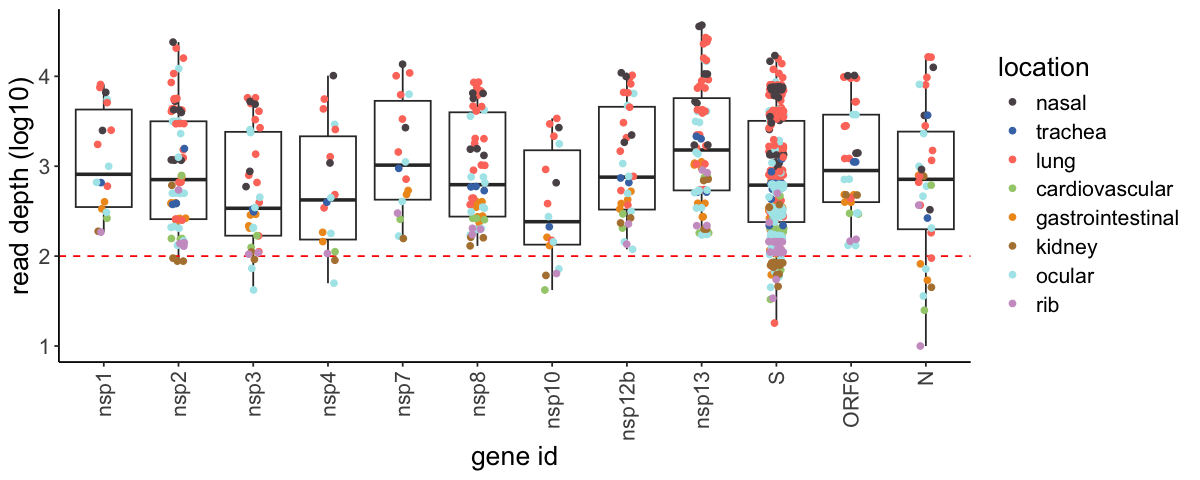

In [64]:
p8 = temp_totalcount %>% filter(!name %in% failures_minor$name & ntpos %in% pull_ntpos) %>%
        ggplot(., aes(y=log10(totalcount), x = gene_id)) + 
            geom_boxplot() + 
            geom_hline(yintercept = log10(minor_cov_stringent), linetype =2 , color = 'red') + 
            geom_jitter(width = 0.1, aes(color = general_location)) + 
            loc_colScale + 
            labs(x='gene id', y = 'read depth (log10)')

print(p8)

#ggsave(p8,
#       filename = glue("{FIG_DIR}/read_depth.gene.{minor_freq}.pdf"),
#       width = 6,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

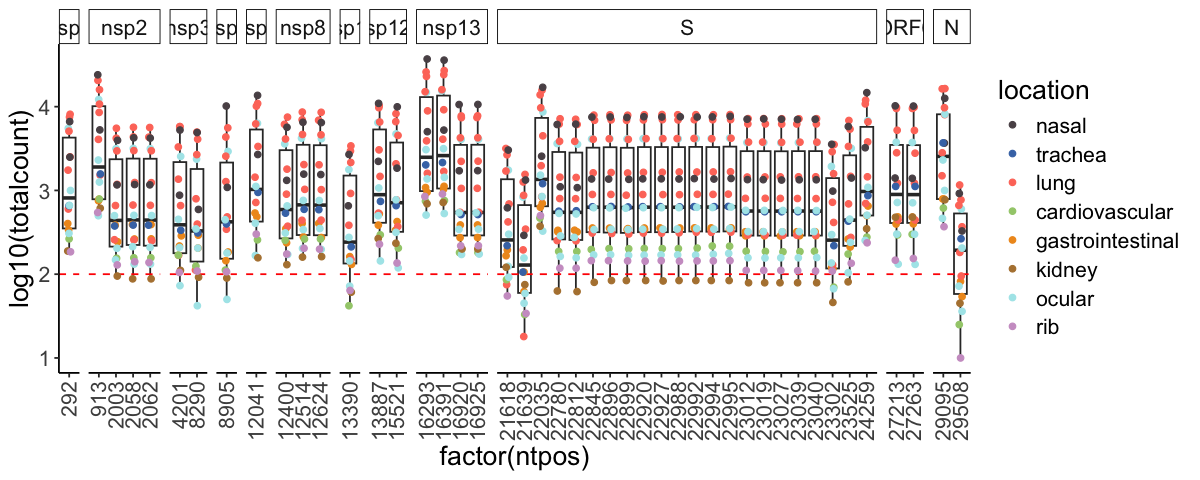

In [65]:
options(repr.plot.width = 10, repr.plot.height = 4)
# break up by specific sites:
p8 = temp_totalcount %>% filter(!name %in% failures_minor$name & ntpos %in% pull_ntpos) %>%
        ggplot(., aes(y=log10(totalcount), x = factor(ntpos))) + 
            geom_boxplot() + 
            geom_hline(yintercept = log10(minor_cov_stringent), linetype =2 , color = 'red') + 
            geom_jitter(width = 0.1, aes(color = general_location)) + 
            loc_colScale + 
            facet_grid(.~gene_id, scales = 'free', space = 'free')

print(p8)


## Minor variants ONLY richness

In [66]:
# prepping metadata for future analyses:
meta_reduced = meta %>% filter(!pacbio_name %in% failures_minor$name)

meta_reduced = merge(meta_reduced, membership, by.x = c('pacbio_name'),by.y=c('name'), all.x = TRUE)

genes = gene_info %>%
    rowwise() %>%
    mutate(gene_length = END-START + 1) %>%
    dplyr::rename('gene_id'='NAME') %>%
    ungroup()

In [67]:
# generate empty df of all combinations
clusters = c(1,2,3)
nonsyn = c('nonsyn','syn')
orf_gene_id = levels(factor(filt_df$orf_gene_id))
name = levels(factor(filt_df$name))

# Generate all combinations so that after merging we can fill in zero's 
combinations_df = expand.grid(name =name, cluster = clusters, nonsyn = nonsyn, orf_gene_id = orf_gene_id)
combinations_df = merge(combinations_df, genes %>% select(gene_id, gene_length), by.x = c('orf_gene_id'), by.y = c('gene_id'))

### MINOR variant richness / gene region (in kb):

In [68]:
richness_gene = filt_df %>% 
            drop_na(varaa) %>%
            filter(vartype == 'minor' &
                    varnt != ay119_nt & 
                    !name %in% failures_minor$name) %>%
            mutate(nonsyn = ifelse(varaa != ay119_aa, 'nonsyn','syn')) # nonsyn information compared to ay119


richness_gene = merge(richness_gene, cluster_df %>% select(name, cluster, cluster_type), by = c('name')) %>%
            group_by(name, orf_gene_id, cluster, nonsyn) %>%
            tally() %>%
            ungroup() # count number of nonsyn/syn mutations per gene and sample

# merge with the combinations table to fill in zeros
richness_gene = merge(richness_gene, combinations_df, by = c('name','cluster','orf_gene_id','nonsyn'), all = TRUE)

richness_gene$n[is.na(richness_gene$n)] = 0 # add zeros for genes that had no syn or nonsyn mutations (compared to ay119)

richness_gene = richness_gene %>%
    mutate(norm_count = n/(gene_length/1000)) %>% # normalize by gene kb
    group_by(cluster, orf_gene_id, gene_length, nonsyn) %>%
    mutate(mean_richness = mean(norm_count), # calculate mean and std dev
          sd_richness = sd(norm_count)) %>%
    ungroup() %>%
    select(-n) %>% # remove info to reduce table
    unique()

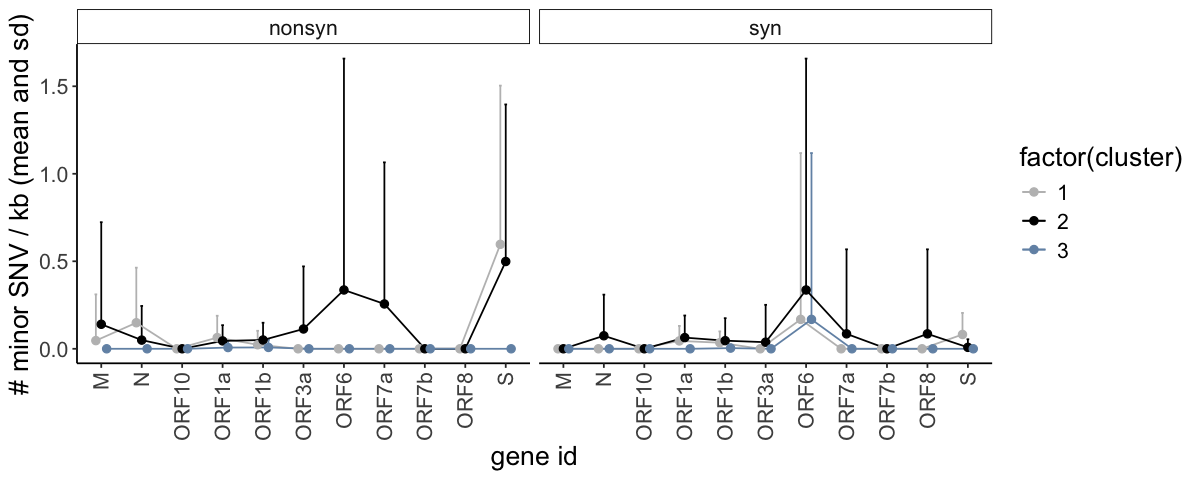

In [69]:
p6 = ggplot(richness_gene %>% select(orf_gene_id, mean_richness, cluster, sd_richness, nonsyn) %>% unique(), 
       aes(x = orf_gene_id, y = mean_richness, color = factor(cluster), group = factor(cluster))) +
  geom_errorbar(aes(ymin = mean_richness, ymax = mean_richness + sd_richness), 
                width = 0.2, 
                position = position_dodge(width = 0.4)) +    # Adjust width for separation
  geom_line(position = position_dodge(width = 0.4)) +       # Use same position_dodge for consistency
  geom_point(size = 2, position = position_dodge(width = 0.4)) + 
  scale_color_manual(values = c('gray', 'black', '#7393b3')) + 
  labs(y = '# minor SNV / kb (mean and sd)', x = 'gene id') +
  facet_grid(. ~ nonsyn)
p6
#ggsave(p6,
#       filename = glue("{FIG_DIR}/richness.gene.cluster.{minor_freq}.pdf"),
#       width = 8,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

#### Minor richness by cluster:

In [70]:
minor_richness = merge(filt_df %>% 
                 filter(!name %in% failures_minor$name & # filter for minors - remove failures
                        vartype == 'minor') %>% 
                 group_by(name) %>%
                 tally(), # tally # of minor vars
                meta, by.x = c('name'), by.y = c('pacbio_name'), all.x = TRUE) # add metadata


minor_richness = merge(minor_richness, cluster_df %>% select(name, cluster, cluster_type), by = c('name')) 

Warning message in wilcox.test.default((minor_richness %>% filter(cluster == 1))$n, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  (minor_richness %>% filter(cluster == 1))$n and (minor_richness %>% filter(cluster == 2))$n
W = 20.5, p-value = 0.05612
alternative hypothesis: true location shift is not equal to 0


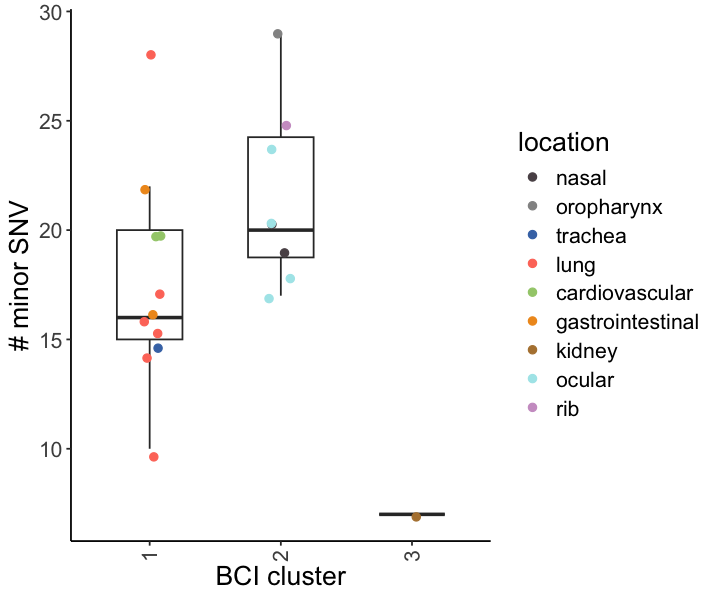

In [71]:
options(repr.plot.width = 6, repr.plot.height = 5)

p6 = minor_richness %>% 
        ggplot(., aes(x=factor(cluster), y=n)) + 
            geom_boxplot(width = 0.5, outlier.shape = NA) + 
            geom_jitter(aes(, color = general_location), width = 0.1, size = 2) +
            loc_colScale + 
            labs(x='BCI cluster', y='# minor SNV')

p6

wilcox.test((minor_richness %>% filter(cluster == 1))$n,
(minor_richness %>% filter(cluster == 2))$n)

#ggsave(p6,
#       filename = glue("{FIG_DIR}/richness.cluster.{minor_freq}.pdf"),
#       width = 5,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)


#### Which samples had the most minor variants?

In [72]:
minor_richness %>% arrange(-n) %>% select(name, n)

name,n
<chr>,<int>
p45_tongue,29
p45_L_superior_lobe,28
p45_rib,25
p45_L_eye_optic_nerve,24
p45_appendix,22
p45_L_ventricle,20
p45_nasal_placode,20
p45_pericardium,20
p45_R_eye_retina,20


#### Mean, SD, median richness for CLUSTER 1

In [73]:
mean((minor_richness %>% filter(cluster == 1))$n)
sd((minor_richness %>% filter(cluster == 1))$n)
median((minor_richness %>% filter(cluster == 1))$n)

[1] 17.54545

[1] 4.782544

[1] 16

#### Mean, SD, Median richness for CLUSTER 2:

In [74]:
mean((minor_richness %>% filter(cluster == 2))$n)
sd((minor_richness %>% filter(cluster == 2))$n)
median((minor_richness %>% filter(cluster == 2))$n)

[1] 21.5

[1] 4.105745

[1] 20


	Welch Two Sample t-test

data:  (minor_richness %>% filter(lower_resp == "yes"))$n and (minor_richness %>% filter(lower_resp == "no"))$n
t = -1.3102, df = 11.677, p-value = 0.2153
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -8.912914  2.231595
sample estimates:
mean of x mean of y 
 16.42857  19.76923 


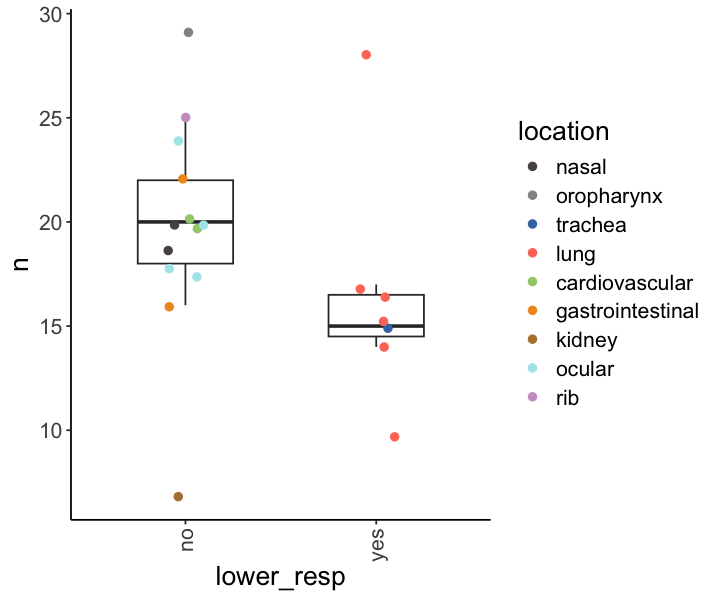

In [75]:
p6 = minor_richness %>% 
    ggplot(., aes(x=lower_resp, y=n)) + 
        geom_boxplot(width = 0.5, outlier.shape = NA) + 
        geom_jitter(aes(, color = general_location), width = 0.1, size = 2) +
        loc_colScale 

p6

#ggsave(p6,
#       filename = glue("{FIG_DIR}/richness.lower_resp.{minor_freq}.pdf"),
#       width = 4,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

t.test((minor_richness %>% filter(lower_resp == 'yes'))$n,
(minor_richness %>% filter(lower_resp == 'no'))$n)


## Calculating divergence and dn/ds (minor variants): 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


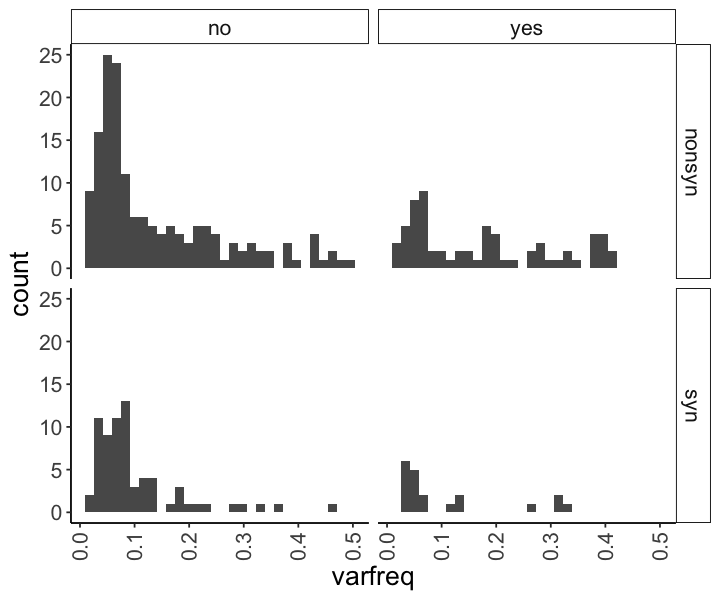

In [76]:
stat_temp = filt_df %>%
            drop_na(gene_id, varaa) %>%
            filter(vartype == 'minor' &
                    varnt != ay119_nt & 
                    !name %in% failures_minor$name & 
                    gene_id %in% cds_regions
                  ) %>%
            mutate(nonsyn = ifelse(varaa != ay119_aa, 'nonsyn','syn')) %>%
            unique()

ggplot(stat_temp, aes(x=varfreq)) +
    geom_histogram() + 
    facet_grid(nonsyn ~ lower_resp)

In [77]:
#(stat_temp %>% filter(lower_resp == 'no' & nonsyn == 'nonsyn'))$varfreq
wilcox.test((stat_temp %>% filter(lower_resp == 'no' & nonsyn == 'nonsyn'))$varfreq,
           (stat_temp %>% filter(lower_resp == 'yes' & nonsyn == 'nonsyn'))$varfreq)

wilcox.test((stat_temp %>% filter(lower_resp == 'no' & nonsyn == 'syn'))$varfreq,
           (stat_temp %>% filter(lower_resp == 'yes' & nonsyn == 'syn'))$varfreq)


	Wilcoxon rank sum test with continuity correction

data:  (stat_temp %>% filter(lower_resp == "no" & nonsyn == "nonsyn"))$varfreq and (stat_temp %>% filter(lower_resp == "yes" & nonsyn == "nonsyn"))$varfreq
W = 4405, p-value = 0.06748
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  (stat_temp %>% filter(lower_resp == "no" & nonsyn == "syn"))$varfreq and (stat_temp %>% filter(lower_resp == "yes" & nonsyn == "syn"))$varfreq
W = 779, p-value = 0.3844
alternative hypothesis: true location shift is not equal to 0


In [78]:
dnds = filt_df %>%
            drop_na(gene_id, varaa) %>%
            filter(vartype == 'minor' &
                    varnt != ay119_nt & 
                    !name %in% failures_minor$name & 
                    gene_id %in% cds_regions # remove non-coding regions
                  ) %>%
            mutate(nonsyn = ifelse(varaa != ay119_aa, 'nonsyn','syn')) %>%
            unique() %>%
        group_by(name, nonsyn) %>%
        mutate(count = n()) %>%
        ungroup() %>%
        select(name, nonsyn, count, general_location, lower_resp, predicted_time, predicted_date, resp) %>%
        unique() %>%
        pivot_wider(names_from = 'nonsyn', values_from = count, values_fill =  0) 

dnds$genome_size = total_positions
dnds$syn_sites = total_syn
dnds$nonsyn_sites = total_nonsyn
dnds$norm_nonsyn = dnds$nonsyn/dnds$nonsyn_sites
dnds$norm_syn = dnds$syn/dnds$syn_sites
dnds$dnds = dnds$norm_nonsyn/dnds$norm_syn
dnds = merge(dnds, cluster_df %>% select(name, cluster, cluster_type), by = c('name'))

In [79]:
# removing the right inferior lobe in calculations as it no syn sites:
t.test((dnds %>% filter(lower_resp == 'yes' & name != 'p45_R_inferior_lobe'))$dnds,
(dnds %>% filter(lower_resp == 'no' & name != 'p45_R_inferior_lobe'))$dnds)


	Welch Two Sample t-test

data:  (dnds %>% filter(lower_resp == "yes" & name != "p45_R_inferior_lobe"))$dnds and (dnds %>% filter(lower_resp == "no" & name != "p45_R_inferior_lobe"))$dnds
t = 0.64104, df = 15.577, p-value = 0.5308
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3699007  0.6895682
sample estimates:
mean of x mean of y 
 1.666667  1.506833 


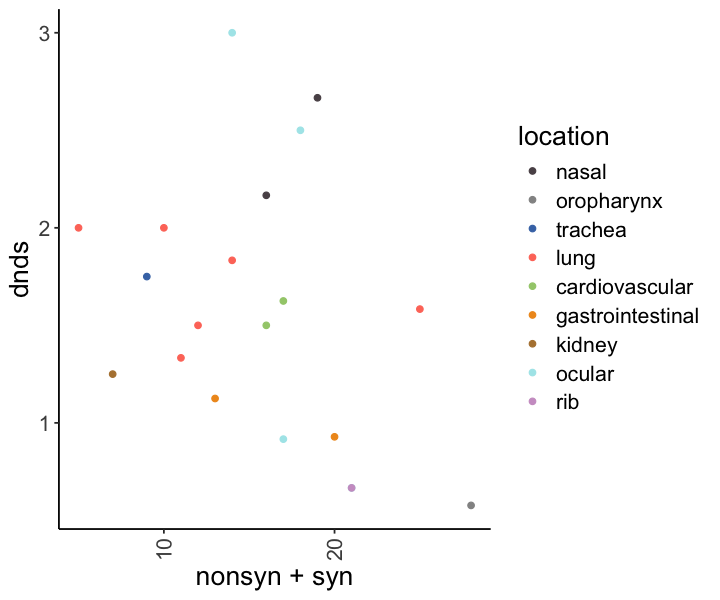

In [80]:
ggplot(dnds, aes(x=nonsyn+syn, y=dnds, color = general_location)) + 
    geom_point() + 
    loc_colScale

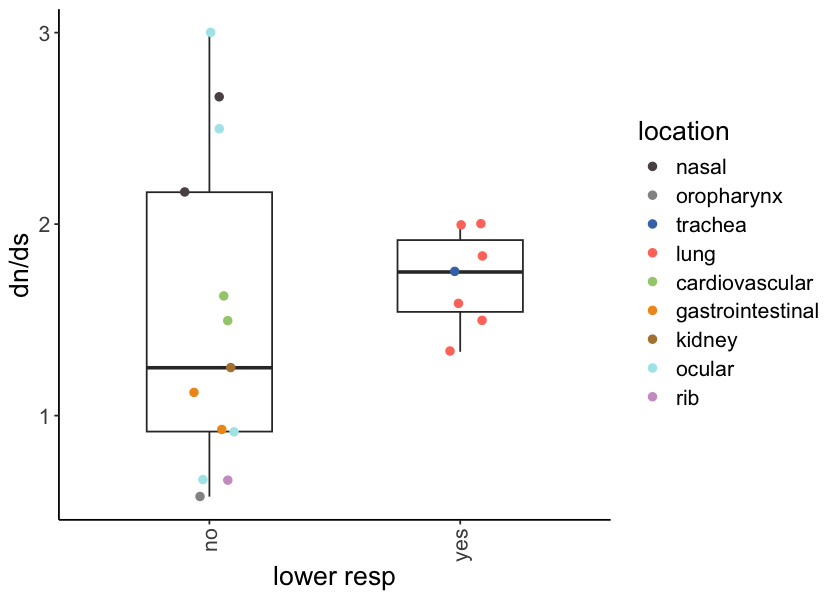

In [81]:
options(repr.plot.width = 7, repr.plot.height = 5)

p8 = ggplot(dnds, aes(x=lower_resp, y = dnds)) +
    geom_boxplot(width = 0.5) + 
    geom_jitter(width = 0.1, size = 2, aes(color = general_location)) + 
    labs(y="dn/ds", x= "lower resp") + 
    loc_colScale
print (p8)

#ggsave(p8,
#       filename = glue("{FIG_DIR}/dnds.lower_resp.{minor_freq}.pdf"),
#       width = 4,
#       height = 4, limitsize=FALSE)

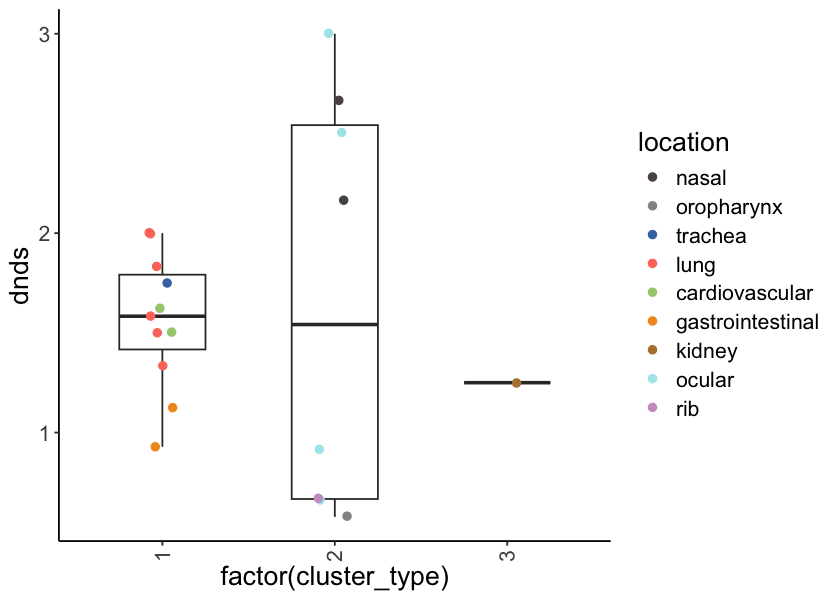

In [82]:

p8 = ggplot(dnds, aes(x=factor(cluster_type), y = dnds)) +
    geom_boxplot(width = 0.5) + 
    geom_jitter(width = 0.1, size = 2, aes(color = general_location)) + 
    loc_colScale 
print (p8)

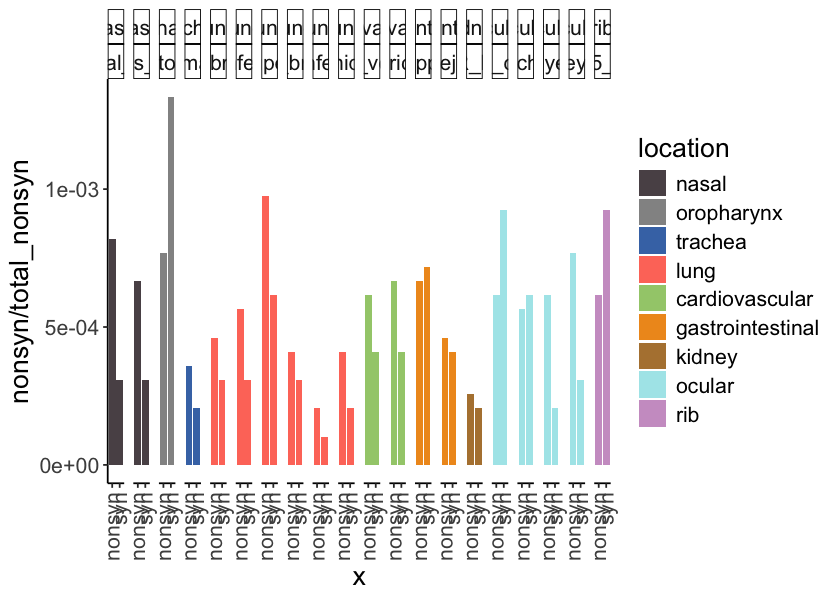

In [83]:
dnds %>% ggplot(.) + 
    geom_col(aes(x='nonsyn', y=nonsyn/total_nonsyn, fill = general_location)) + 
    geom_col(aes(x='syn', y=syn/total_syn, fill = general_location)) + 
    loc_colScale_fill +
    facet_grid(.~general_location + name)

In [84]:
div_genome = filt_df %>%
            drop_na(gene_id, varaa) %>%
            filter(vartype == 'minor' &
                    varnt != ay119_nt & 
                    !name %in% failures_minor$name & 
                    gene_id %in% cds_regions # remove non-coding regions
                  ) %>%
            mutate(nonsyn = ifelse(varaa != ay119_aa, 'nonsyn','syn')) %>%
            unique() %>%
        group_by(name, nonsyn) %>%
        mutate(summed_div = sum(varfreq)) %>%
        ungroup() %>%
        select(name, nonsyn, summed_div, general_location, lower_resp, resp) %>%
        unique() %>%
        pivot_wider(names_from = 'nonsyn', values_from = summed_div, values_fill =  0) 

div_genome = merge(div_genome, cluster_df %>% select(name, cluster, cluster_type), by = c('name'))
div_genome$normalized_syn = div_genome$syn/total_syn
div_genome$normalized_nonsyn = div_genome$nonsyn/total_nonsyn

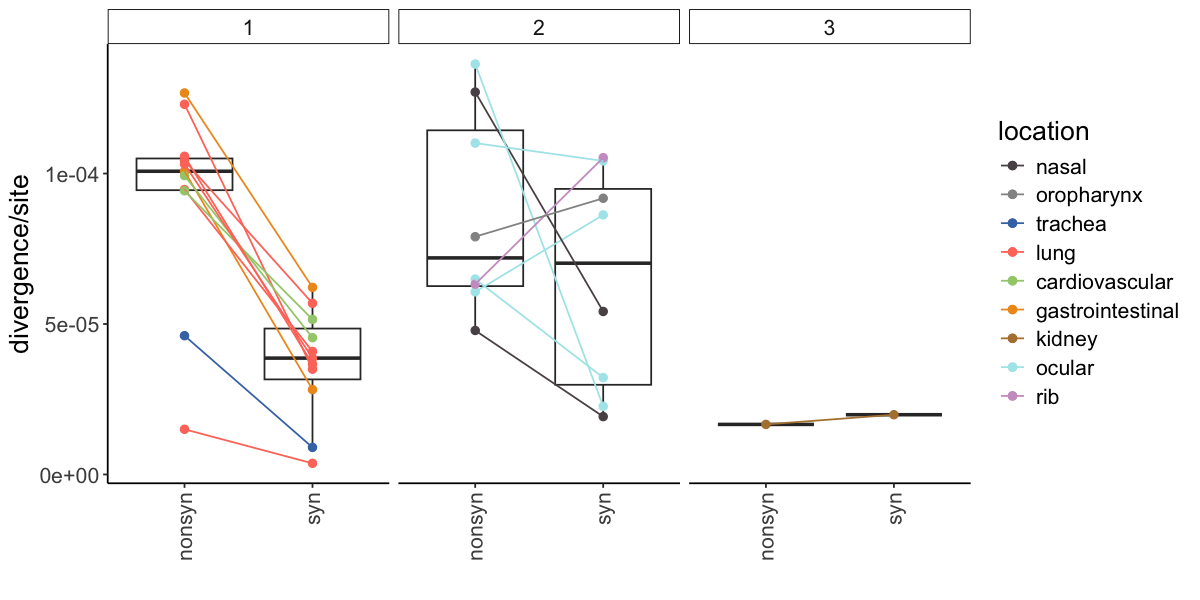

In [85]:
# add cluster type
options(repr.plot.width = 10, repr.plot.height = 5)

p2 = ggplot() + 
        geom_boxplot(data = div_genome, aes(x='nonsyn', y = normalized_nonsyn)) +
        geom_boxplot(data = div_genome, aes(x='syn', y = normalized_syn)) +
        geom_point(data = div_genome, aes(x='nonsyn', y = normalized_nonsyn, color = general_location), size = 2) +
        geom_point(data = div_genome, aes(x='syn', y = normalized_syn, color = general_location), size = 2) +
        geom_segment(data = div_genome, aes(color = general_location, 
                                            x = 'nonsyn',xend = 'syn',y= normalized_nonsyn, yend =normalized_syn )) + 
        
        labs(y="divergence/site",x="") +
        loc_colScale + 
        facet_grid(.~factor(cluster_type), scales = 'free', space = 'free')
p2

#ggsave(p2,
#       filename = glue("{FIG_DIR}/divergence.cluster.{minor_freq}.pdf"),
#       width = 6,
#       height = 4, limitsize=FALSE)

#### Stats for sig tests:

In [86]:
wilcox.test((div_genome %>% filter(cluster_type == 1))$normalized_nonsyn,
(div_genome %>% filter(cluster_type == 1))$normalized_syn)


wilcox.test((div_genome %>% filter(cluster_type == 2))$normalized_nonsyn,
(div_genome %>% filter(cluster_type == 2))$normalized_syn)


wilcox.test((div_genome %>% filter(cluster_type == 1))$normalized_nonsyn,
(div_genome %>% filter(cluster_type == 2))$normalized_nonsyn)


wilcox.test((div_genome %>% filter(cluster_type == 1))$normalized_syn,
(div_genome %>% filter(cluster_type == 2))$normalized_syn)


	Wilcoxon rank sum exact test

data:  (div_genome %>% filter(cluster_type == 1))$normalized_nonsyn and (div_genome %>% filter(cluster_type == 1))$normalized_syn
W = 109, p-value = 0.0007655
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  (div_genome %>% filter(cluster_type == 2))$normalized_nonsyn and (div_genome %>% filter(cluster_type == 2))$normalized_syn
W = 43, p-value = 0.2786
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  (div_genome %>% filter(cluster_type == 1))$normalized_nonsyn and (div_genome %>% filter(cluster_type == 2))$normalized_nonsyn
W = 47, p-value = 0.8404
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  (div_genome %>% filter(cluster_type == 1))$normalized_syn and (div_genome %>% filter(cluster_type == 2))$normalized_syn
W = 28, p-value = 0.206
alternative hypothesis: true location shift is not equal to 0


#### Cluster 1 mean and median nonsyn and syn calcs:

In [87]:
mean((div_genome %>% filter(cluster_type == 1))$nonsyn)
median((div_genome %>% filter(cluster_type == 1))$nonsyn)
mean((div_genome %>% filter(cluster_type == 1))$syn)
median((div_genome %>% filter(cluster_type == 1))$nonsyn)

[1] 1.79685

[1] 1.965797

[1] 0.361898

[1] 1.965797

#### Cluster 2 mean and median nonsyn and syn calcs: 

In [88]:
mean((div_genome %>% filter(cluster_type == 2))$nonsyn)
median((div_genome %>% filter(cluster_type == 2))$nonsyn)
mean((div_genome %>% filter(cluster_type == 2))$syn)
median((div_genome %>% filter(cluster_type == 2))$nonsyn)

[1] 1.680979

[1] 1.404015

[1] 0.6288476

[1] 1.404015

In [89]:
#### Broken up by upper and lower resp tissues:

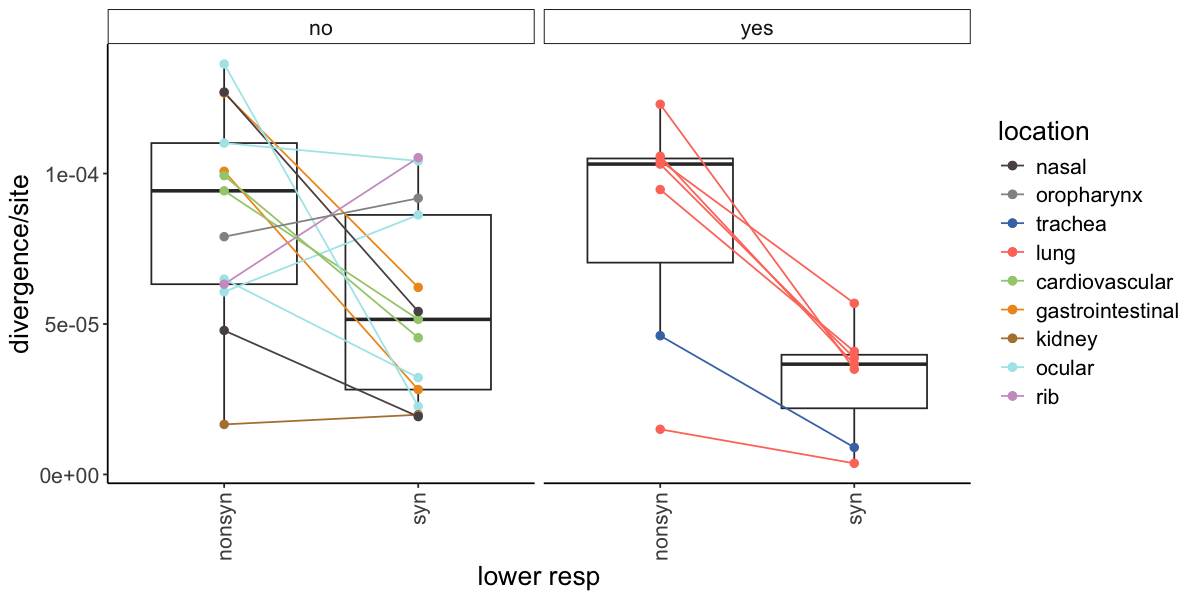

In [90]:
options(repr.plot.width = 10, repr.plot.height = 5)

p2 = ggplot() + 
    geom_boxplot(data = div_genome, aes(x='nonsyn', y = nonsyn/total_nonsyn)) +
    geom_boxplot(data = div_genome, aes(x='syn', y = syn/total_syn)) +
    geom_segment(data = div_genome, aes(color = general_location, 
                                        x = 'nonsyn',xend = 'syn',y= nonsyn/total_nonsyn, yend =syn/total_syn)) + 
    geom_point(data = div_genome, aes(x='nonsyn', y = nonsyn/total_nonsyn, color = general_location), size = 2) +
    geom_point(data = div_genome, aes(x='syn', y = syn/total_syn, color = general_location), size = 2) +

    labs(y="divergence/site",x="lower resp") +
    loc_colScale + 
    facet_grid(.~factor(lower_resp), scales = 'free', space = 'free')
p2

#ggsave(p2,
#       filename = glue("{FIG_DIR}/divergence.lower_resp.{minor_freq}.pdf"),
#       width = 6,
#       height = 4, limitsize=FALSE)

In [91]:
t.test((div_genome %>% filter(lower_resp == 'yes'))$nonsyn,
(div_genome %>% filter(lower_resp == 'yes'))$syn)


t.test((div_genome %>% filter(lower_resp == 'no'))$nonsyn,
(div_genome %>% filter(lower_resp == 'no'))$syn)


	Welch Two Sample t-test

data:  (div_genome %>% filter(lower_resp == "yes"))$nonsyn and (div_genome %>% filter(lower_resp == "yes"))$syn
t = 4.5498, df = 6.6921, p-value = 0.002956
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.6381185 2.0464660
sample estimates:
mean of x mean of y 
1.6499259 0.3076336 



	Welch Two Sample t-test

data:  (div_genome %>% filter(lower_resp == "no"))$nonsyn and (div_genome %>% filter(lower_resp == "no"))$syn
t = 5.4969, df = 16.741, p-value = 4.149e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7074374 1.5904530
sample estimates:
mean of x mean of y 
1.6913986 0.5424534 


In [92]:
print('syn')
t.test((div_genome %>% filter(lower_resp == 'no'))$syn,
(div_genome %>% filter(lower_resp == 'yes'))$syn)

print('nonsyn')
t.test((div_genome %>% filter(lower_resp == 'no'))$nonsyn,
(div_genome %>% filter(lower_resp == 'yes'))$nonsyn)

[1] "syn"



	Welch Two Sample t-test

data:  (div_genome %>% filter(lower_resp == "no"))$syn and (div_genome %>% filter(lower_resp == "yes"))$syn
t = 2.1242, df = 17.747, p-value = 0.04798
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.002330539 0.467308988
sample estimates:
mean of x mean of y 
0.5424534 0.3076336 


[1] "nonsyn"



	Welch Two Sample t-test

data:  (div_genome %>% filter(lower_resp == "no"))$nonsyn and (div_genome %>% filter(lower_resp == "yes"))$nonsyn
t = 0.12047, df = 11.347, p-value = 0.9062
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7133868  0.7963322
sample estimates:
mean of x mean of y 
 1.691399  1.649926 


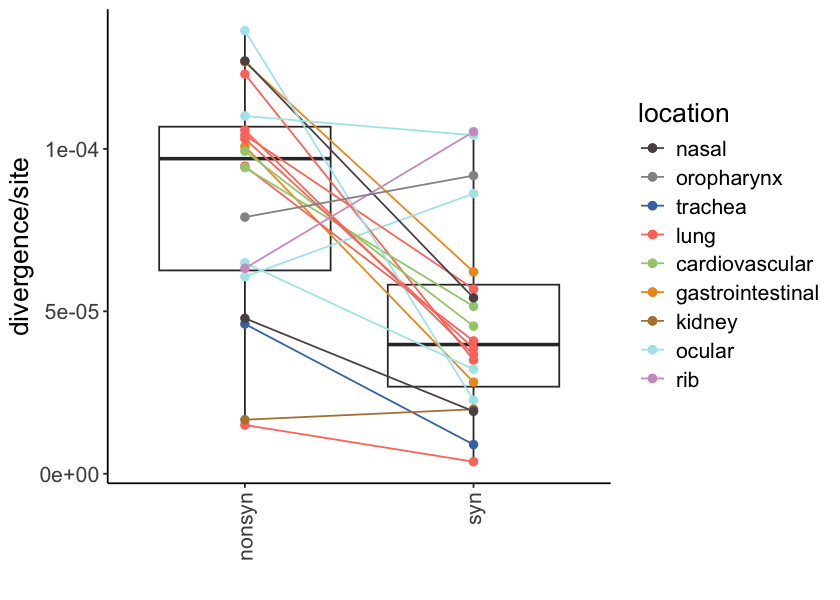

In [93]:
options(repr.plot.width = 7, repr.plot.height = 5)

p3 = ggplot() + 
    geom_boxplot(data = div_genome, aes(x='nonsyn', y = nonsyn/total_nonsyn)) +
    geom_boxplot(data = div_genome, aes(x='syn', y = syn/total_syn)) +
    geom_segment(data = div_genome, aes(color = general_location, 
                                        x = 'nonsyn', xend = 'syn', 
                                        y= nonsyn/total_nonsyn, yend =syn/total_syn)) + 
    geom_point(data = div_genome, aes(x='nonsyn', y = nonsyn/total_nonsyn, color = general_location), size = 2) +
    geom_point(data = div_genome, aes(x='syn', y = syn/total_syn, color = general_location), size = 2) +
    
    labs(y="divergence/site",x="") +
    loc_colScale

p3 

#ggsave(p3,
#       filename = glue("{FIG_DIR}/divergence.all.{minor_freq}.pdf"),
#       width = 5,
#       height = 4, limitsize=FALSE)

## Total minor richness comparisons

In [94]:
total_richness = filt_df %>%
            drop_na(gene_id, varaa) %>%
            filter(vartype == 'minor' &
                   !name %in% failures_minor$name & 
                   gene_id %in% cds_regions # remove non-coding region
                  ) %>%
            group_by(name, general_location, predicted_time) %>%
            tally() 

total_richness = merge(total_richness, meta,
                       by.x = c('name','general_location','predicted_time'),
                       by.y =c('pacbio_name','general_location','predicted_time'), 
                      all.x = TRUE)

`geom_smooth()` using formula = 'y ~ x'


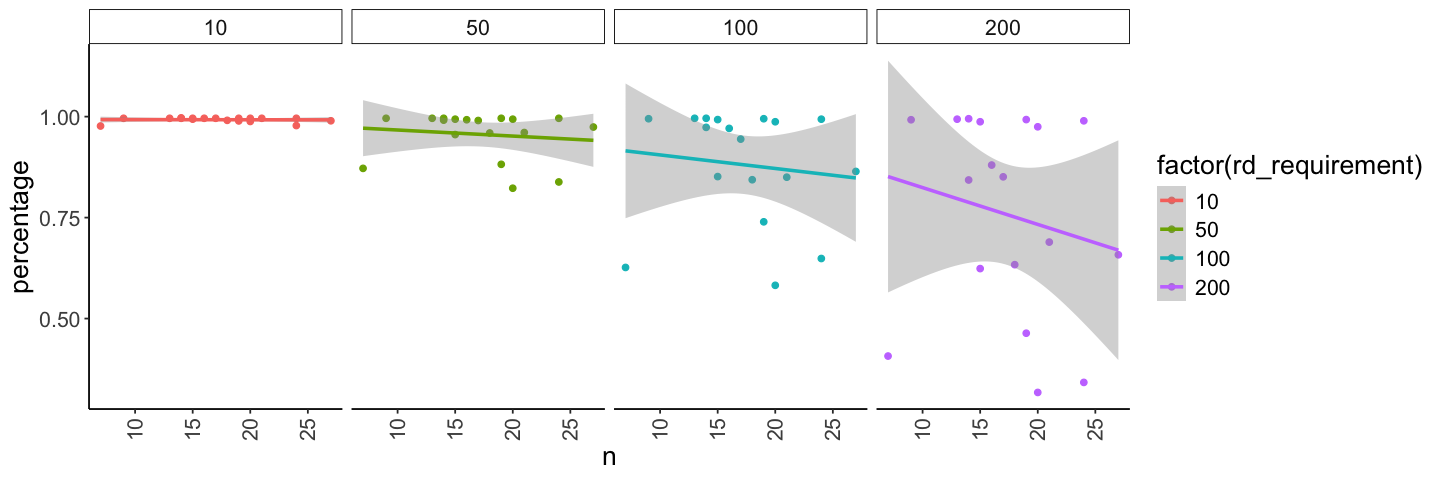

In [95]:
# Richness versus coverage:
options(repr.plot.width = 12, repr.plot.height = 4)
merge(total_richness, COV_DF1, by = c('name'))  %>%
    ggplot(aes(x=n, y = percentage, group = rd_requirement, color = factor(rd_requirement))) + 
        geom_point() +
        geom_smooth(method = 'lm') +
        facet_grid(.~factor(rd_requirement), space = 'free', scales = 'free')

`geom_smooth()` using formula = 'y ~ x'


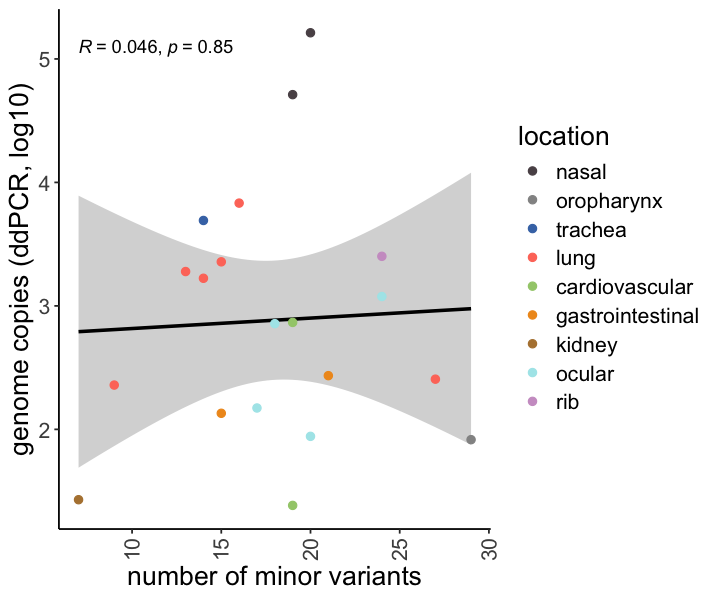

In [96]:
# richness vs. ddPCR values:
options(repr.plot.width = 6, repr.plot.height = 5)

p11 = total_richness %>%
    ggplot(aes(x=n, y = log10(ddPCR))) + 
    geom_smooth(method = 'lm', color = 'black') +
    geom_point(aes(color = general_location),size = 2) +
    loc_colScale + 
    stat_cor(method = 'pearson') +
    labs(y= "genome copies (ddPCR, log10)", x = "number of minor variants")


p11
#ggsave(p11,
#       filename = glue("{FIG_DIR}/cor.ddpcr.richness.{minor_freq}.pdf"),
#       width = 6,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

`geom_smooth()` using formula = 'y ~ x'


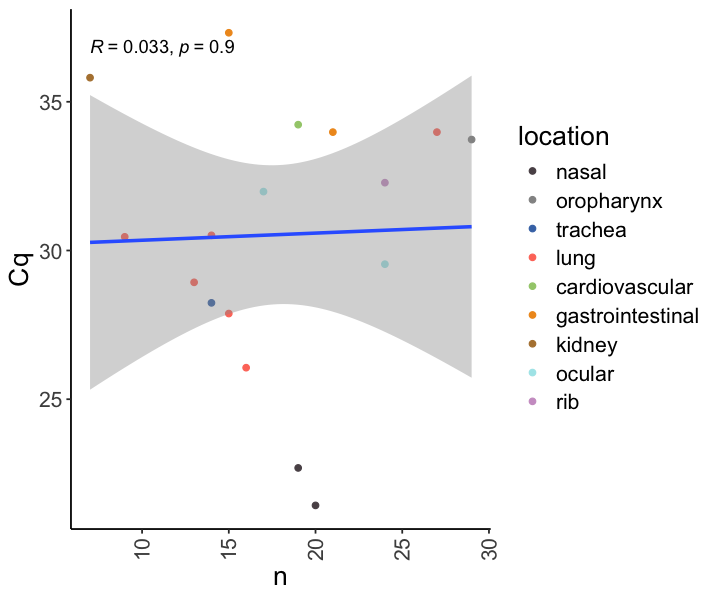

In [97]:
# richness vs. Cq sgRNA values 
options(repr.plot.width = 6, repr.plot.height = 5)

total_richness = total_richness %>% drop_na(Cq)

total_richness %>%
    ggplot(aes(x=n, y = Cq)) + 
    geom_point(aes(color = general_location)) +
    loc_colScale + 
    geom_smooth(method = 'lm') +
    stat_cor()

In [98]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: aarch64-apple-darwin20.0.0 (64-bit)
Running under: macOS 14.7.2

Matrix products: default
BLAS/LAPACK: /opt/anaconda3/envs/renv1/lib/libopenblas.0.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Biostrings_2.66.0   GenomeInfoDb_1.34.9 XVector_0.38.0     
 [4] IRanges_2.32.0      S4Vectors_0.36.2    BiocGenerics_0.44.0
 [7] ggpubr_0.6.0        gggenes_0.5.1       igraph_2.0.3       
[10] viridis_0.6.5       viridisLite_0.4.2   pals_1.9           
[13] glue_1.7.0          lubridate_1.9.3     forcats_1.0.0      
[16] stringr_1.5.1       dplyr_1.1.4         purrr_1.0.2        
[19] readr_2.1.5         tidyr_1.3.1         tibble_3.2.1       
[22] tidyverse_2.0.0     plyr_1.8.9          reshape2_1.4.4     
[25] ggplot2_3.5.1      

loaded via a namespace (and not attached):
 [1] 